Uploading data

In [1]:
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=vz-jH8T_Uk2c
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.csv to train.csv
User uploaded file "train.csv" with length 68597919 bytes


2. importing required packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import nnls
from tqdm import tqdm
import re
import string

#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
# from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3. EDA on the dataset plus splitting of train and test and validation

In [14]:
# https://github.com/amitrajitbose/toxic-comment-classification/blob/master/EDA.ipynb

df = pd.read_csv('/content/train.csv')
# df2 = pd.read_csv('/content/test.csv')
# df = pd.concat([df1, df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [15]:
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [16]:
# dropping id and comment text
df_toxic = df.drop(['id', 'comment_text'], axis=1)
# calculating total count of each category comments
counts = []
categories = list(df_toxic.columns.values)

for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'count'])
df_stats

,category,count
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


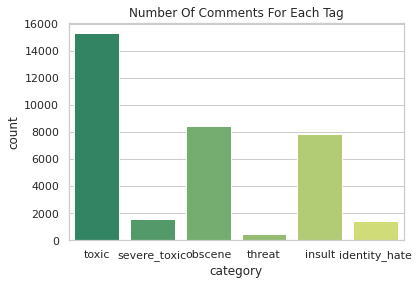

In [17]:
# df_toxic.sum().plot(kind="bar")

sns.set(style="whitegrid")
sns.barplot(x='category', y='count', data=df_stats, palette="summer")
plt.title("Number Of Comments For Each Tag")
plt.show()

Comments having multiple labels

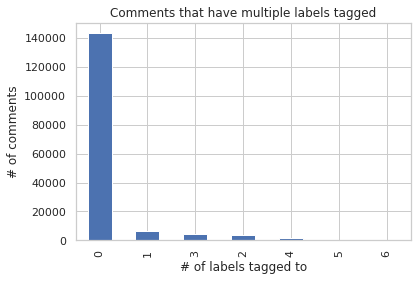

89.83211235124176 % comments have no labels associated to them.


In [18]:
rowsums = df_toxic.iloc[:,:].sum(axis=1)
valcount = rowsums.value_counts()
valcount.plot.bar()
plt.xlabel("# of labels tagged to")
plt.ylabel("# of comments")
plt.title("Comments that have multiple labels tagged")
plt.show()

print(valcount[0]*100/sum(valcount),"% comments have no labels associated to them.")

~90 % comments have no labels associated to them.
This essentially shows that a large amount of the entire dataset is tagged to none of the six labels.

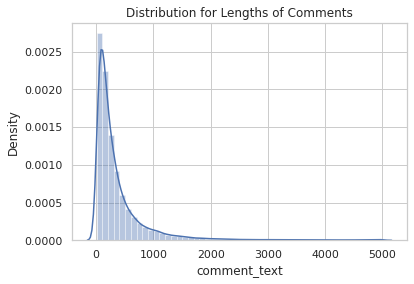

In [19]:
lens = df.comment_text.str.len()
sns.distplot(lens)
plt.title("Distribution for Lengths of Comments")
plt.show()


Class imabalance

https://notebook.community/Diyago/Machine-Learning-scripts/NLP/text%20analyses/Toxic%20EDA#https://en.wikipedia.org/wiki/Sparse_matrix

In [20]:
x=df.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=df.iloc[:,2:].sum(axis=1)
df['clean']=(rowsums==0)
#count number of clean entries
df['clean'].sum()
print("Total comments = ",len(df))
print("Total clean comments = ",df['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


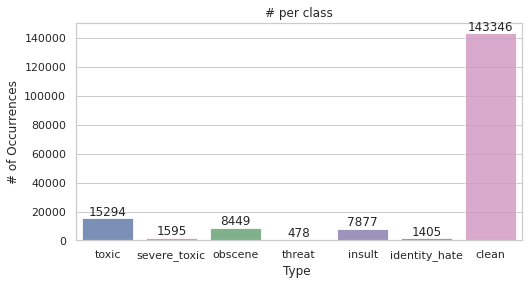

In [21]:
# x=df.iloc[:,2:].sum()
# #plot
# plt.figure(figsize=(8,4))
# ax= sns.barplot(x.index, x.values, alpha=0.8)
# plt.title("# per class")
# plt.ylabel('# of Occurrences', fontsize=12)
# plt.xlabel('Type ', fontsize=12)
# #adding the text labels
# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

# plt.show()

x=df.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

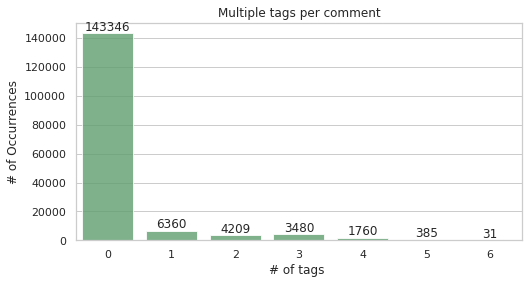

In [22]:
x=rowsums.value_counts()
color = sns.color_palette()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<Axes: >

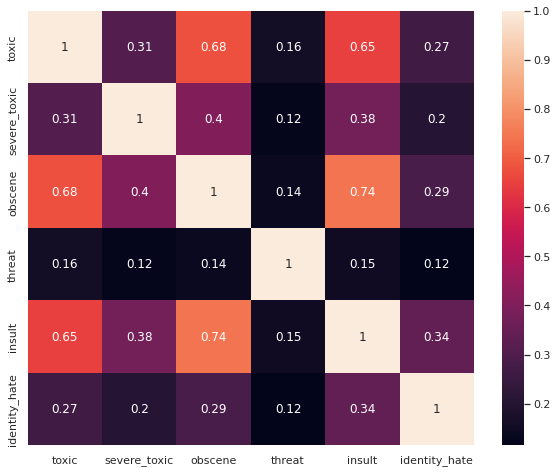

In [23]:
temp_df=df.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.

So, to find a pattern between two categorical variables we can use other tools like

Confusion matrix/Crosstab
Cramer's V Statistic
Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured

In [24]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes.

Some interesting observations:

A Severe toxic comment is always toxic
Other classes seem to be a subset of toxic barring a few exceptions

In [25]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
import scipy.stats as ss

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#Checking for Toxic and Severe toxic for now
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30850290540548614


Example Comments:

In [26]:
# Example comments in each cluster
print("toxic:")
print(df[df.severe_toxic==1].iloc[3,1])
print("============================\n\n")

print("severe_toxic:")
print(df[df.severe_toxic==1].iloc[4,1])
print("============================\n\n")

print("Threat:")
print(df[df.threat==1].iloc[1,1])
print("============================\n\n")

print("Obscene:")
print(df[df.obscene==1].iloc[1,1])
print("============================\n\n")

print("identity_hate:")
print(df[df.identity_hate==1].iloc[4,1])
print("============================\n\n")


toxic:
Hi 

Im a fucking bitch.

50.180.208.181


severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum 

Observations:
-- Few comments contain same thing.
-- Also comments contains IP addresses and usernames which are not relevant



# **Feature engineering:**

Direct features:
Features which are a directly due to words/content.We would be exploring the following techniques

checkinf for

--count of sentences

--count of words

--count of unique words

--count of letters

--count of punctuations

--count of uppercase words/letters

--count of stop words

--Avg length of each word


From the example, we know that the comments contain identifier information (eg: IP, username,etc.). We can create features out of them but, it will certainly lead to overfitting to this specific Wikipedia use-case.

--toxic IP scores

--toxic users

Note: Creating the indirect and leaky features first. There are two reasons for this,

Count features(Direct features) are useful only if they are created from a clean corpus
Also the indirect features help compensate for the loss of information when cleaning the dataset

In [27]:

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [28]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

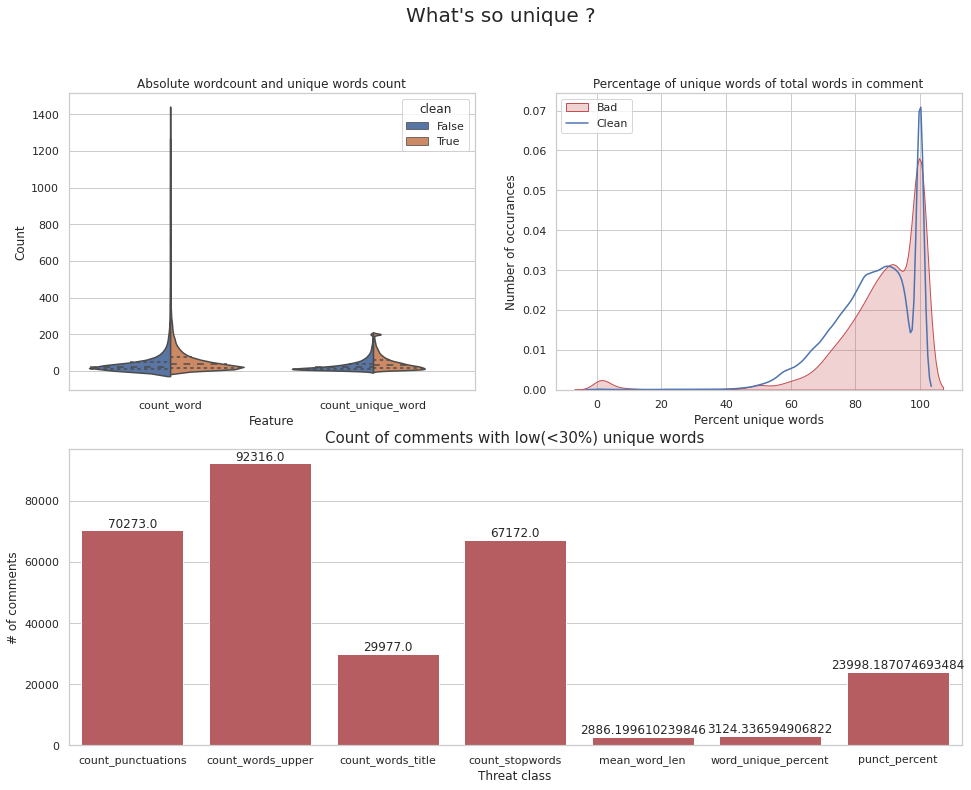

In [29]:
df['count_unique_word'].loc[df['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(df, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 40% unique words
spammers=df[df['word_unique_percent']<30]

plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(df[df.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(df[df.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

In [30]:
#Leaky features
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
df['count_ip']=df["ip"].apply(lambda x: len(x))

#links
df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
df['count_links']=df["link"].apply(lambda x: len(x))

#article ids
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

#username
##              regex for     Match anything with [[User: ---------- ]]
# regexp = re.compile("\[\[User:(.*)\|")
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))
#check if features are created
#df.username[df.count_usernames>0]

# Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))


# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [31]:
df[df.count_usernames!=0].comment_text.iloc[0]


'2010]]\n[[User talk:Wikireader41/Archive4|Archive 5-Mar 15'

In [32]:
# check few names
cv.get_feature_names_out()[120:130]

array(['king', 'koshvorlon', 'kuban', 'kungming2', 'lance6968',
       'likelakers2', 'lopez', 'lucasbfr', 'lumos3', 'luna'], dtype=object)

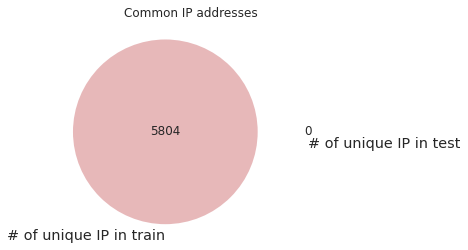

In [33]:
leaky_feats=df[["ip","link","article_id","username","count_ip","count_links","count_usernames","article_id_flag"]]
leaky_feats_train=leaky_feats.iloc[:df.shape[0]]
leaky_feats_test=leaky_feats.iloc[df.shape[0]:]


#filterout the entries without ips
train_ips=leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips=leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
#get the unique list of ips in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_ip_list),len(test_ip_list),len(common_ip_list)),set_labels=("# of unique IP in train","# of unique IP in test"))
plt.show()

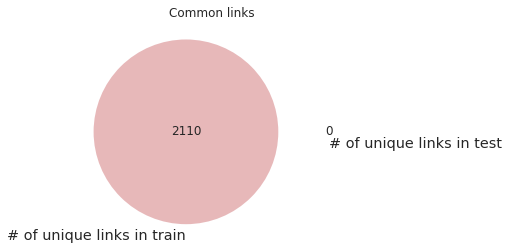

In [34]:
#filterout the entries without links
train_links=leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links=leaky_feats_test.link[leaky_feats_test.count_links!=0]
#get the unique list of ips in test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common links")
venn.venn2(subsets=(len(train_links_list),len(test_links_list),len(common_links_list)),
           set_labels=("# of unique links in train","# of unique links in test"))
plt.show()

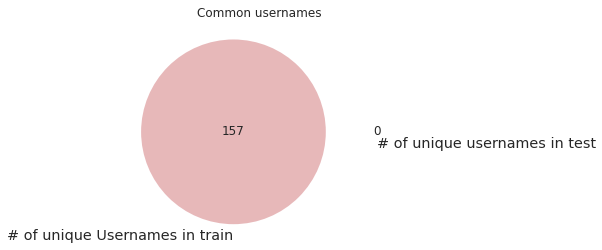

In [35]:
#filterout the entries without users
train_users=leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users=leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
#get the unique list of ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique Usernames in train","# of unique usernames in test"))
plt.show()

In [36]:
#https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs)

blocked_ips=["216.102.6.176",
"216.120.176.2",
"203.25.150.5",
"203.217.8.30",
"66.90.101.58",
"125.178.86.75",
"210.15.217.194",
"69.36.166.207",
"213.25.24.253",
"24.60.181.235",
"71.204.14.32",
"216.91.92.18",
"212.219.2.4",
"194.74.190.162",
"64.15.152.246",
"59.100.76.166",
"146.145.221.129",
"146.145.221.130",
"74.52.44.34",
"68.5.96.201",
"65.184.176.45",
"209.244.43.209",
"82.46.9.168",
"209.200.236.32",
"209.200.229.181",
"202.181.99.22",
"220.233.226.170",
"212.138.64.178",
"220.233.227.249",
"72.14.194.31",
"72.249.45.0/24",
"72.249.44.0/24",
"80.175.39.213",
"81.109.164.45",
"64.157.15.0/24",
"208.101.10.54",
"216.157.200.254",
"72.14.192.14",
"204.122.16.13",
"217.156.39.245",
"210.11.188.16",
"210.11.188.17",
"210.11.188.18",
"210.11.188.19",
"210.11.188.20",
"64.34.27.153",
"209.68.139.150",
"152.163.100.0/24",
"65.175.48.2",
"131.137.245.197",
"131.137.245.199",
"131.137.245.200",
"64.233.172.37",
"66.99.182.25",
"67.43.21.12",
"66.249.85.85",
"65.175.134.11",
"201.218.3.198",
"193.213.85.12",
"131.137.245.198",
"83.138.189.74",
"72.14.193.163",
"66.249.84.69",
"209.204.71.2",
"80.217.153.189",
"83.138.136.92",
"83.138.136.91",
"83.138.189.75",
"83.138.189.76",
"212.100.250.226",
"212.100.250.225",
"212.159.98.189",
"87.242.116.201",
"74.53.243.18",
"213.219.59.96/27",
"212.219.82.37",
"203.38.149.226",
"66.90.104.22",
"125.16.137.130",
"66.98.128.0/17",
"217.33.236.2",
"24.24.200.113",
"152.22.0.254",
"59.145.89.17",
"71.127.224.0/20",
"65.31.98.71",
"67.53.130.69",
"204.130.130.0/24",
"72.14.193.164",
"65.197.143.214",
"202.60.95.235",
"69.39.89.95",
"88.80.215.14",
"216.218.214.2",
"81.105.175.201",
"203.108.239.12",
"74.220.207.168",
"206.253.55.206",
"206.253.55.207",
"206.253.55.208",
"206.253.55.209",
"206.253.55.210",
"66.64.56.194",
"70.91.90.226",
"209.60.205.96",
"202.173.191.210",
"169.241.10.83",
"91.121.195.205",
"216.70.136.88",
"72.228.151.208",
"66.197.167.120",
"212.219.232.81",
"208.86.225.40",
"63.232.20.2",
"206.219.189.8",
"212.219.14.0/24",
"165.228.71.6",
"99.230.151.129",
"72.91.11.99",
"173.162.177.53",
"60.242.166.182",
"212.219.177.34",
"12.104.27.5",
"85.17.92.13",
"91.198.174.192/27",
"155.246.98.61",
"71.244.123.63",
"81.144.152.130",
"198.135.70.1",
"71.255.126.146",
"74.180.82.59",
"206.158.2.80",
"64.251.53.34",
"24.29.92.238",
"76.254.235.105",
"68.96.242.239",
"203.202.234.226",
"173.72.89.88",
"87.82.229.195",
"68.153.245.37",
"216.240.128.0/19",
"72.46.129.44",
"66.91.35.165",
"82.71.49.124",
"69.132.171.231",
"75.145.183.129",
"194.80.20.237",
"98.207.253.170",
"76.16.222.162",
"66.30.100.130",
"96.22.29.23",
"76.168.140.158",
"202.131.166.252",
"89.207.212.99",
"81.169.155.246",
"216.56.8.66",
"206.15.235.10",
"115.113.95.20",
"204.209.59.11",
"27.33.141.67",
"41.4.65.162",
"99.6.65.6",
"60.234.239.169",
"2620:0:862:101:0:0:2:0/124",
"183.192.165.31",
"50.68.6.12",
"37.214.82.134",
"96.50.0.230",
"60.231.28.109",
"64.90.240.50",
"49.176.97.12",
"209.80.150.137",
"24.22.67.116",
"206.180.81.2",
"195.194.39.100",
"87.41.52.6",
"169.204.164.227",
"50.137.55.117",
"50.77.84.161",
"90.202.230.247",
"186.88.129.224",
"2A02:EC80:101:0:0:0:2:0/124",
"142.4.117.177",
"86.40.105.198",
"120.43.20.149",
"198.199.64.0/18",
"192.34.56.0/21",
"192.81.208.0/20",
"2604:A880:0:0:0:0:0:0/32",
"108.72.107.229",
"2602:306:CC2B:7000:41D3:B92D:731C:959D",
"185.15.59.201",
"180.149.1.229",
"207.191.188.66",
"210.22.63.92",
"117.253.196.217",
"119.160.119.172",
"90.217.133.223",
"194.83.8.3",
"194.83.164.22",
"217.23.228.149",
"65.18.58.1",
"168.11.15.2",
"65.182.127.31",
"207.106.153.252",
"64.193.88.2",
"152.26.71.2",
"199.185.67.179",
"117.90.240.73",
"108.176.58.170",
"195.54.40.28",
"185.35.164.109",
"192.185.0.0/16",
"2605:E000:1605:C0C0:3D3D:A148:3039:71F1",
"107.158.0.0/16",
"85.159.232.0/21",
"69.235.4.10",
"86.176.166.206",
"108.65.152.51",
"10.4.1.0/24",
"103.27.227.139",
"188.55.31.191",
"188.53.13.34",
"176.45.58.252",
"176.45.22.37",
"24.251.44.140",
"108.200.140.191",
"117.177.169.4",
"72.22.162.38",
"24.106.242.82",
"79.125.190.93",
"107.178.200.1",
"123.16.244.246",
"83.228.167.87",
"128.178.197.53",
"14.139.172.18",
"207.108.136.254",
"184.152.17.217",
"186.94.29.73",
"217.200.199.2",
"66.58.141.104",
"166.182.81.30",
"89.168.206.116",
"92.98.163.145",
"77.115.31.71",
"178.36.118.74",
"157.159.10.14",
"103.5.212.139",
"203.174.180.226",
"69.123.252.95",
"199.200.123.233",
"121.45.89.82",
"71.228.87.155",
"68.189.67.92",
"216.161.176.152",
"98.17.30.139",
"2600:1006:B124:84BD:0:0:0:103",
"117.161.0.0/16",
"12.166.68.34",
"96.243.149.64",
"74.143.90.218",
"76.10.176.221",
"104.250.128.0/19",
"185.22.183.128/25",
"89.105.194.64/26",
"202.45.119.0/24",
"73.9.140.64",
"164.127.71.72",
"50.160.129.2",
"49.15.213.207",
"83.7.192.0/18",
"201.174.63.79",
"2A02:C7D:4643:8F00:D09D:BE1:D2DE:BB1F",
"125.60.195.230",
"49.145.113.145",
"168.18.160.134",
"72.193.218.222",
"199.216.164.10",
"120.144.130.89",
"104.130.67.208",
"50.160.221.147",
"163.47.141.50",
"91.200.12.136",
"83.222.0.0/19",
"67.231.16.0/20",
"72.231.0.196",
"180.216.68.197",
"183.160.178.135",
"183.160.176.16",
"24.25.221.150",
"92.222.109.43",
"142.134.243.215",
"216.181.221.72",
"113.205.170.110",
"74.142.2.98",
"192.235.8.3",
"2402:4000:BBFC:36FC:E469:F2F0:9351:71A0",
"80.244.81.191",
"2607:FB90:1377:F765:D45D:46BF:81EA:9773",
"2600:1009:B012:7D88:418B:54BA:FCBC:4584",
"104.237.224.0/19",
"2600:1008:B01B:E495:C05A:7DD3:926:E83C",
"168.8.249.234",
"162.211.179.36",
"138.68.0.0/16",
"145.236.37.195",
"67.205.128.0/18",
"2A02:C7D:2832:CE00:B914:19D6:948D:B37D",
"107.77.203.212",
"2607:FB90:65C:A136:D46F:23BA:87C2:3D10",
"2A02:C7F:DE2F:7900:5D64:E991:FFF0:FA93",
"82.23.32.186",
"106.76.243.74",
"82.33.48.223",
"180.216.160.0/19",
"94.102.184.35",
"94.102.184.26",
"109.92.162.54",
"2600:8800:7180:BF00:4C27:4591:347C:736C",
"178.41.186.50",
"184.97.134.128",
"176.221.32.0/22",
"207.99.40.142",
"109.97.241.134",
"82.136.64.19",
"91.236.74.119",
"197.210.0.0/16",
"173.230.128.0/19",
"162.216.16.0/22",
"80.111.222.211",
"191.37.28.21",
"124.124.103.194",
"50.207.7.198",
"220.233.131.98",
"107.77.241.11",
"68.112.39.0/27",
"173.236.128.0/17",
"49.49.240.24",
"96.31.10.178",
"50.251.229.75"]

train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
blocked_ip_list_train=list(set(train_ip_list).intersection(blocked_ips))
blocked_ip_list_test=list(set(test_ip_list).intersection(blocked_ips))

print("There are",len(blocked_ip_list_train),"blocked IPs in train dataset")
print("There are",len(blocked_ip_list_test),"blocked IPs in test dataset")

There are 6 blocked IPs in train dataset
There are 0 blocked IPs in test dataset


An interesting but somewhat insignificant finding. There are 6 blocked IP mentions in the comments overall.

Anyways, moving on to cleaning the dataset.

# Text preprocessing:

In [37]:
# Spacy implementation

import spacy
nlp = spacy.load("en_core_web_sm")

from spacy.lang.en.stop_words import STOP_WORDS
stop = STOP_WORDS

from numpy import NaN
# collect total no of tokens
total_tokens =[]
def text_preprocessing(text):
  tokens = []
  input=text
  #remove \n
  input=re.sub("\\n","",input)
  # remove leaky elements like ip,user
  input=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",input)
  #removing usernames
  input=re.sub("\[\[.*\]","",input)

  doc = nlp(text)
  # print(type(doc))
  for t in doc:
    if not t.is_stop and not t.is_punct and not t.is_space and t.text.isalpha() == True :

    # if not t.is_stop and not t.is_punct and not t.is_space and t.text.isalpha() == True and t.pos_  in ['ADJ','ADV','INTJ','DET','NOUN','PROPN','PRON','VERB']:
      tokens.append(t.lemma_.lower())
      total_tokens.append(t.lemma_.lower())
  if not tokens:
    return None
  return tokens




# Example usage:
# print(clean("Of all the things I miss, I miss my mind the most."))
text_preprocessing("Of all the things I miss, I miss my i'd mind the most.")


['thing', 'miss', 'miss', 'mind']

Deleting comments with no labels ~90% comments .16225 is the remaining count . Please not that this data is still multilabeled

In [38]:
print(len(df)) #159571
# df_ready = df.copy()
df_ready = df[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']].copy()

print(len(df_ready))#159571
df_ready = df_ready.drop(df_ready[(df_ready.toxic == 0) & (df_ready.severe_toxic == 0) & (df_ready.obscene == 0) & (df_ready.threat == 0) & (df_ready.insult == 0) & (df_ready.identity_hate == 0) ].index)

print(len(df_ready)) #16225
# df = df.drop(df[(df.severe_toxic == 0) & (df.obscene == 0) & (df.threat == 0) & (df.insult == 0) & (df.identity_hate == 0) ].index)

# # df = df.drop(df[(df.toxic == 0) & (df.severe_toxic == 0) & (df.obscene == 0) & (df.threat == 0) & (df.insult == 0) & (df.identity_hate == 0) ].index)
# print(len(df)) #16225


159571
159571
16225


In [39]:
df_ready.columns


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

# Apply text preprocessing of data to create new column of clean text tokens

In [40]:
df_ready['clean_data'] = df_ready['comment_text'].apply(text_preprocessing)

In [41]:
# saving a copy as a checkpoint to save time
df_copy=df_ready.copy()
# df_ready=df_copy.copy()
# df_sampled = naive_df.copy()
# df_ready.to_csv('final_clean_dataset.csv')

# df_ready = pd.read_csv('/content/final_clean_dataset.csv')

# No of comments 'toxic' label is mapped to




In [42]:
count_of_toxic_multi_class_labels=0
for i, row in df_ready.iterrows():
  if(row.iloc[2]==1 and (row.iloc[3]==1 or row.iloc[4]==1 or row.iloc[5]==1 or row.iloc[6]==1 or row.iloc[7]==1  )): count_of_toxic_multi_class_labels+=1

count_of_toxic_multi_class_labels
print(count_of_toxic_multi_class_labels,' of toxic labels are mapped to some other class which is ',round(float(count_of_toxic_multi_class_labels*100/16225 ),3),'% of total comments')


# 8132  of obscene labels are mapped to some other class which is  50.12 % of total comments
# 9628  of toxic labels are mapped to some other class which is  59.341 % of total comments
# 7576  of insult labels are mapped to some other class which is  46.693 % of total comments


9628  of toxic labels are mapped to some other class which is  59.341 % of total comments




---



# 9628  of toxic labels are mapped to some other class which is  59.34052388289676  of total comments.
Dropping the 'toxic' label as it has high correlation with all other labels which means that it is 'linked' strongly with all other labels so it's a good idea to drop it.



---





---



In [43]:
toxic_labels = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_ready = df_ready.drop('toxic', axis=1)
df_ready.columns

Index(['id', 'comment_text', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'clean_data'],
      dtype='object')

In [44]:
count_cl = 0
for i, row in df_ready.iterrows():
  # if(count_cl <10): 
    if(row[2]==0 and (row[3]==0 and row[4]==0 and row[5]==0 and row[6]==0   )): 
      # print(i)
      # print(row)
      # print('------')
      count_cl+=1
  # if(row.iloc[2]==0 and (row.iloc[3]==0 and row.iloc[4]==0 and row.iloc[5]==0 and row.iloc[6]==0   )): 
  #   count_cl+=1
    # print(row)
print('no of zero labels ',count_cl)

# after dropping toxic the items with only toxic will have all 0s

print(len(df_ready))#16225
df_ready = df_ready.drop(df_ready[ (df_ready.severe_toxic == 0) & (df_ready.obscene == 0) & (df_ready.threat == 0) & (df_ready.insult == 0) & (df_ready.identity_hate == 0) ].index)
print('no of zero labels after',count_cl)

print(len(df_ready)) #10559

no of zero labels  5666
16225
10559


In [45]:
count_cl = 0
for i, row in df_ready.iterrows():
  # if(count_cl <10): 
    if(row[2]==0 and (row[3]==0 and row[4]==0 and row[5]==0 and row[6]==0   )): 
      # print(i)
      # print(row)
      # print('------')
      count_cl+=1

count_cl

0

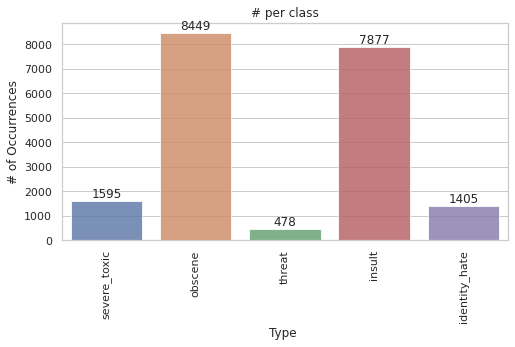

total no of samples 10559


In [46]:
x=df_ready.iloc[:,2:8].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.xticks(rotation=90)

plt.show()
print('total no of samples 10559')



---



-- total no of samples 10559.

-- multiclass data

-- highly imbalanced data






---



In [47]:
# correlation plot for labels
df_labels = df_ready[toxic_labels]

corr = df_labels.corr()
corr.style.background_gradient(cmap='coolwarm')


,severe_toxic,obscene,threat,insult,identity_hate
severe_toxic,1.000000,0.159211,0.050624,0.110047,0.078463
obscene,0.159211,1.000000,-0.092827,-0.080494,-0.064321
threat,0.050624,-0.092827,1.000000,-0.051894,0.046135
insult,0.110047,-0.080494,-0.051894,1.000000,0.071662
identity_hate,0.078463,-0.064321,0.046135,0.071662,1.000000


Here are some observations based on the correlation matrix:

-- The categories of severe_toxic and obscene have a moderate positive correlation coefficient of 0.159211, indicating that these two categories tend to occur together.

-- The categories of obscene and threat have a negative correlation coefficient of -0.092827, indicating that these two categories tend to occur separately.

--The categories of severe_toxic and insult have a positive correlation coefficient of 0.110047, indicating that these two categories tend to occur together.

-- The categories of insult and identity_hate have a positive correlation coefficient of 0.071662, indicating that these two categories tend to occur together.

Overall, the correlation matrix provides insights into the relationships between different categories of toxic comments, which can be useful in designing models for identifying and classifying toxic comments.



 The below table shows the simplified conditional probabilities of each label: given the label denoted by the column, the chance an item in the dataset also matches the label denoted by the row. Recall that every example of severe_toxic was also an example of toxic? You can see that this is represented here, since p(toxic|severe)= 1 and p(obscene|severe)= 0.17 (row 1, column 2 in the matrix below).



In [48]:
# conditional probability matrix
def build_conditional_prob_matrix(df, labels):
    cooc = df[labels].values.T.dot(df[labels].values)
    cooc_norm = cooc.copy().astype(np.float32)
    for i in range(cooc_norm.shape[0]):
        cooc_norm[:, i] /= cooc[i, i]
    return cooc_norm

cooc_norm = build_conditional_prob_matrix(df_ready, toxic_labels)
cooc_df = pd.DataFrame(cooc_norm, columns = toxic_labels, index = toxic_labels)
cooc_df.style.background_gradient(cmap = 'coolwarm')

,severe_toxic,obscene,threat,insult,identity_hate
severe_toxic,1.000000,0.179548,0.234310,0.174051,0.222776
obscene,0.951097,1.000000,0.629707,0.781389,0.734520
threat,0.070219,0.035626,1.000000,0.038974,0.069751
insult,0.859561,0.728489,0.642259,1.000000,0.825623
identity_hate,0.196238,0.122145,0.205021,0.147264,1.000000


This is a conditional probability matrix, which shows the probability of a comment belonging to one category given that it belongs to another category. The values in the matrix represent conditional probabilities and range from 0 to 1.

Here are some observations based on the conditional probability matrix:

The highest conditional probability values appear on the diagonal of the matrix, where a category is compared to itself. This is because the probability of a comment belonging to a category given that it belongs to the same category is always 1.

-- The category of severe_toxic has the highest conditional probability with the categories of obscene and insult, which are 0.179548 and 0.174051, respectively. This indicates that if a comment is classified as severe_toxic, there is a higher likelihood that it will also be classified as obscene or insult.

--The categories of severe_toxic and obscene have a high conditional probability value of 0.951097, indicating that if a comment is classified as severe_toxic, there is a high likelihood that it will also be classified as obscene.

--The categories of threat and identity_hate have the highest conditional probability value with themselves, which are 1.000000. This indicates that if a comment is classified as either threat or identity_hate, there is a high likelihood that it will also be classified as the same category.

-- The categories of threat and identity_hate have low conditional probability values with the other categories, indicating that if a comment is classified as either of these categories, it is less likely to be classified as any of the other categories.

We can use this conditional probability to determine the most likely rank of each label. More on this

<Axes: >

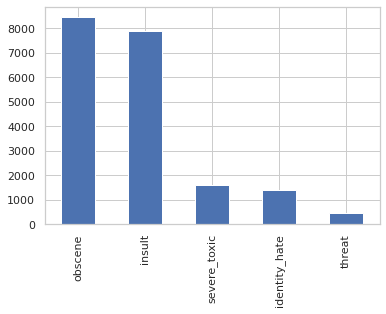

In [49]:
label_counts = df_labels.sum().to_dict()
df_labels[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()

<Axes: >

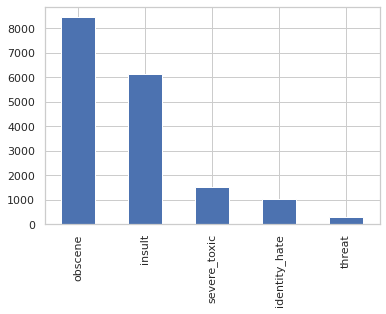

In [50]:
# counts per label for examples that have severe_toxic label
df_ready[df_ready['obscene'] == 1][sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()


# Now let's move onto conversion of multilabel data into multi class data using Association rule mining (support measure)



In [51]:
df_ready.reset_index(drop=True, inplace=True)
# df_labels.shape

In [52]:
# , non_negative_factorization
# globar vars
# create a dicitonary to get frequency of each label

label_counts = df_labels.sum().to_dict()

# count the total no of rows where label A and label B occur together
def count_intersection(labelA,labelB):
  return len(df_labels[(df_labels[labelA]==1) & (df_labels[labelB]==1)])

def count_intersection_multiple(input_list):

  j =1
    
  intersect =set(df_ready.index[df_ready[input_list[0]] == 1].tolist())
  # lenA =len(setA)
  while(j<len(input_list)):
      setB = set(df_ready.index[df_ready[input_list[j]] == 1].tolist())

      intersect = intersect.intersection(setB)

      j=j+1

  count = len(intersect)
  return count



intersection_counts={}
# Global vars for A and B occuring together
for i in range(len(toxic_labels)):
  j=i+1
  while j<len(toxic_labels):    
    intersection_counts[toxic_labels[i]+'_'+toxic_labels[j]] = count_intersection(toxic_labels[i],toxic_labels[j])
    j=j+1




In [53]:
# power set
total_len=df_ready.shape[0]
total_len

10559

[1517, 112, 1371, 313, 301, 6155, 1032, 307, 98, 1160]


{'severe_toxic_obscene': 1517,
 'severe_toxic_threat': 112,
 'severe_toxic_insult': 1371,
 'severe_toxic_identity_hate': 313,
 'obscene_threat': 301,
 'obscene_insult': 6155,
 'obscene_identity_hate': 1032,
 'threat_insult': 307,
 'threat_identity_hate': 98,
 'insult_identity_hate': 1160}

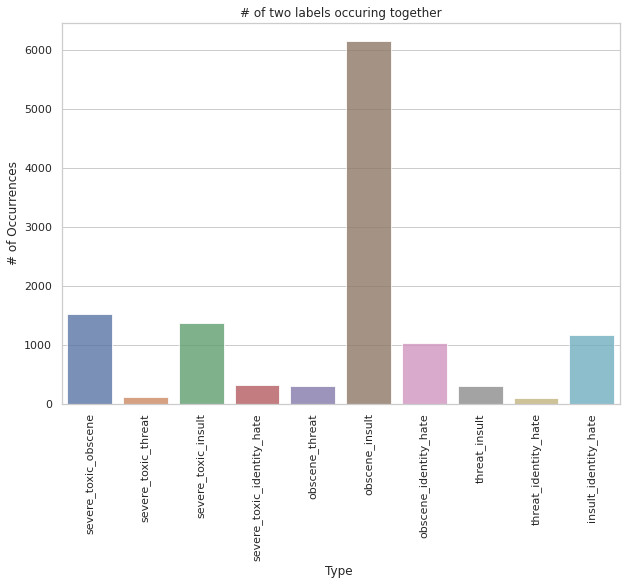

In [54]:
# No of times label A and label B co-occur

x=list(intersection_counts.keys())
y=list(intersection_counts.values())
print(y)
#plot
plt.figure(figsize=(10,7))
ax= sns.barplot(x=x, y=y, alpha=0.8)
plt.title("# of two labels occuring together")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
plt.xticks(rotation=90)


intersection_counts


# Obscene and insult co occur together signinficantly more than others

Let's use the association rule mining methods to assign labels to each sample where the confidence is more.
i.e. determining which label does this sample more likely to fall into?

Refer: CLASSIFICATION ON MULTI-LABEL DATASET USING RULE
MINING TECHNIQUE
https://ijret.org/volumes/2014v03/i06/IJRET20140306028.pdf

https://repositorium.sdum.uminho.pt/bitstream/1822/36011/1/1038.pdf



In [55]:
def get_list_oflabels(df_in):
  # return(df_in[1])
  list_of_labels=[]
  for j in range(2,7):
    if(df_in.iloc[j] == 1 ): list_of_labels.append(toxic_labels[j-2])
  return list_of_labels

def get_label_for_max_lift_score(list_of_labels):
  length =list(list_of_labels)
  # min_confidence_score= 1e9 + 7
  min_confidence_score= 0

  min_label=''
  for i in range(len(list_of_labels)):
    # print('For i=',list_of_labels[i])
    j=i
    labA = list_of_labels[i]
    labB = list(set(list_of_labels) - set(labA))
    # score_lift = count_intersection_multiple(list_of_labels)
    score_lift = ( count_intersection_multiple(list_of_labels)/label_counts[list_of_labels[i]] )/( count_intersection_multiple(labB)/total_len)
    # while(j<len(list_of_labels) ): 

 
      # int_key = list_of_labels[i]+'_'+list_of_labels[j]
      # score = 
      # score_i+=  (intersection_counts[int_key] / label_counts[list_of_labels[i]])

    if(score_lift > min_confidence_score):
      min_confidence_score = score_lift
      min_label = list_of_labels[i]
      # j=j+1
  return min_label

def get_label_formax_confidence_score(list_of_labels):
  length =list(list_of_labels)
  max_confidence_score= 0
  max_label=''
  for i in range(len(list_of_labels)):
    # print('For i=',list_of_labels[i])
    j=i+1
    score_i=0
    while(j<len(list_of_labels) ): 
      # print('For i=',list_of_labels[i] ,' and j= ',list_of_labels[j] )
      # print('initial j score',score_i)
      # if(list_of_labels[i]+'_'+list_of_labels[j] in intersection_counts.keys() ):
      #   print('1 ',list_of_labels[i]+'_'+list_of_labels[j])
      # else:         print('2 ',list_of_labels[i]+'_'+list_of_labels[j])
      int_key = list_of_labels[i]+'_'+list_of_labels[j]
      # print('int_key = ',int_key)
      # print('int_score = ',intersection_counts[int_key])
      # print('i score = ',label_counts[list_of_labels[i]])

      score_i+=  (intersection_counts[int_key] / label_counts[list_of_labels[i]])
      # print('score = ',score_i)
      # print('===========')
      if(score_i > max_confidence_score):
        max_confidence_score = score_i
        max_label = list_of_labels[i]
      j=j+1
  # print('Max label = ',max_label ,' with score ',max_confidence_score)
  return max_label


    #   if( list_of_labels[k]+'_'+list_of_labels[l] in intersection_counts.keys()):
    #     score = ()/()

# print(df_ready.head(5))
for i, row in df_ready.iterrows():
# for i in range(len(df.index)):
  # print('Row ',df.iloc[i,1][0:50])
  # l1=get_list_oflabels(df.iloc[i,:])
  l1=get_list_oflabels(row)

  # print('get_list_oflabels ',l1)
  # if(len(l1)==0): print(l1,' ',row)

  if(len(l1) >1):
    most_imp_label = get_label_formax_confidence_score(l1)
    # print('most_imp_label ',most_imp_label)
    l2= [j for j in toxic_labels if j!=most_imp_label]
    # print('l2 ',l2)
    for  j in l2:
      df_ready.at[i,j] = 0
      # df.loc[i, [j]] = ['0']
    # df.loc[i ,label] = 0 if label in l2 else 1
    # print('=========')

# print(df_ready.head(5))


In [56]:
# Counting rows for 0 labels
count_cl = 0
for i, row in df_ready.iterrows():
  if(row.iloc[2]==0 and (row.iloc[3]==0 and row.iloc[4]==0 and row.iloc[5]==0 and row.iloc[6]==0   )): count_cl+=1
count_cl

# df_ready.columns

0

**Below is the multiclass representation of dataset**.
We can see that the resultant dataset is highly imbalanced

{'severe_toxic': 1595, 'obscene': 6932, 'threat': 164, 'insult': 1678, 'identity_hate': 190}


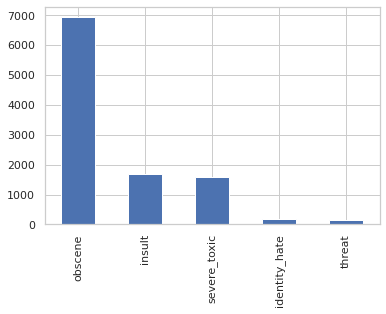

In [57]:
df_labels1 =  df_ready[toxic_labels]

label_counts2 = df_labels1.sum().to_dict()

df_ready[sorted(label_counts2.keys(), key = label_counts2.get, reverse = True)].sum().plot.bar()
print(label_counts2)

# confidence:
# {'severe_toxic': 1595, 'obscene': 6932, 'threat': 164, 'insult': 1678, 'identity_hate': 190}

# import matplotlib.pyplot as plt

# data = {'milk': 60, 'water': 10}
# names = list(label_counts2.keys())
# values = list(label_counts2.values())

# plt.bar(names, values, tick_label=names)
# plt.show()

**Our data is still highly imbalanced after conversion to multiclass which is expected. Oversampling using data augmentation**

In [ ]:
# df_ready[df_ready['threat'] == 1][sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()



---
# Data augmentztion


In [60]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-03-18 21:33:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-18 21:33:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-18 21:33:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov



---



**Splitting the dataset into train,test and validation set in 60-20-20 ratio before data augmentation.
So as to perform data augmentation only on train set**

In [61]:
import numpy as np
# import pandas as pd

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

training_df,validation_df,testing_df = train_validate_test_split(df_ready,0.6, 0.2, seed=None)

In [62]:
training_df.columns

Index(['id', 'comment_text', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'clean_data'],
      dtype='object')

In [63]:
# dropping id and comment text
df_toxic_training = training_df.drop(['id', 'comment_text','clean_data'], axis=1)
# calculating total count of each category comments
counts = []
categories_train = list(df_toxic_training.columns.values)

for i in categories_train:
    counts.append((i, df_toxic_training[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'count'])
df_stats

,category,count
0,severe_toxic,950
1,obscene,4189
2,threat,97
3,insult,983
4,identity_hate,116


In [64]:
# dropping id and comment text
df_toxic_test = testing_df.drop(['id', 'comment_text','clean_data'], axis=1)
# calculating total count of each category comments
counts = []
categories_test = list(df_toxic_test.columns.values)

for i in categories_test:
    counts.append((i, df_toxic_test[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'count'])
df_stats

,category,count
0,severe_toxic,316
1,obscene,1366
2,threat,33
3,insult,365
4,identity_hate,33


In [65]:
# dropping id and comment text
df_toxic_val = validation_df.drop(['id', 'comment_text','clean_data'], axis=1)
# calculating total count of each category comments
counts = []
categories_val = list(df_toxic_val.columns.values)

for i in categories_val:
    counts.append((i, df_toxic_val[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'count'])
df_stats

,category,count
0,severe_toxic,329
1,obscene,1377
2,threat,34
3,insult,330
4,identity_hate,41


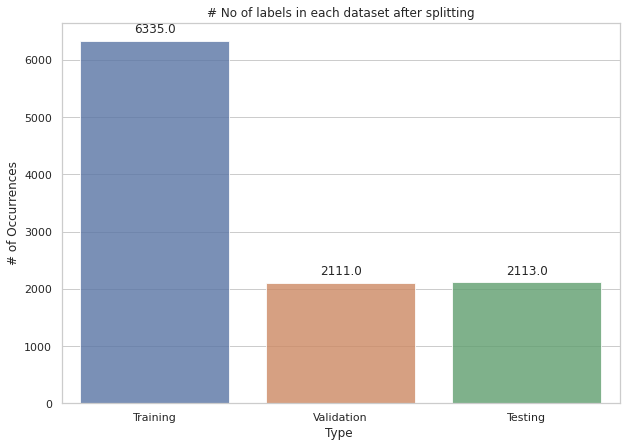

In [66]:
x=['Training','Validation','Testing']
y=[training_df.shape[0],validation_df.shape[0],testing_df.shape[0],]
# print(y)
#plot
plt.figure(figsize=(10,7))
ax= sns.barplot(x=x, y=y,alpha=0.8)

plt.title("# No of labels in each dataset after splitting")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
# plt.xticks(rotation=90)

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

In [67]:
# import os
# path_to_glove_file = os.path.join(
#     os.path.expanduser("~"), ".keras/datasets/glove.6B.100d.txt"
# )
# print(path_to_glove_file)
def loadEmbeddingMatrix(typeToLoad, vocab_dict):
    import gensim.models.keyedvectors as word2vec
    import gc

    # load different embedding file from Kaggle depending on which embedding
    # matrix we are going to experiment with
    # if (typeToLoad == "gloveTwitter50d"):
    #     EMBEDDING_FILE = 'embeddings\glove-twitter-27b-50d/glove.twitter.27B.50d.txt'
    #     embed_size = 50
    # elif (typeToLoad == "word2vec"):
    #     word2vecDict = word2vec.KeyedVectors.load_word2vec_format( "embeddings\GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin", binary=True)
    #     embed_size = 300
    # elif (typeToLoad == "fasttext"):
    #     EMBEDDING_FILE = 'embeddings\\fasttext/wiki.simple.vec'
    #     embed_size = 300
    # elif (typeToLoad == "glove840B300D"):
    #     EMBEDDING_FILE = 'embeddings\glove.840B.300d/glove.840B.300d.txt'
    #     embed_size = 300
    if (typeToLoad == "glove6B300D"):
        EMBEDDING_FILE = '/content/glove.6B.300d.txt'
        print('here')
        embed_size = 300
    # elif (typeToLoad == "paragram"):
    #     EMBEDDING_FILE = 'embeddings\paragram_300_sl999\paragram_300_sl999.txt'
    #     embed_size = 300
    # elif (typeToLoad == "wikiNews"):
    #     EMBEDDING_FILE = "embeddings\wiki-news-300d-1M\wiki-news-300d-1M.vec"
    #     embed_size = 300
    # if (typeToLoad == "glove6B100D"):
    #     EMBEDDING_FILE = path_to_glove_file
    #     embed_size = 100

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    if (typeToLoad in ["gloveTwitter50d", "fasttext"]):
        embeddings_index = dict()
        # Transfer the embedding weights into a dictionary by iterating through every line of the file.
        f = open(EMBEDDING_FILE)
        for line in f:
            # split up line into an indexed array
            values = line.rstrip().rsplit(' ')  # line.split()
            # first index is word
            word = values[0]
            # store the rest of the values in the array as a new array
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs  # 50 dimensions
        f.close()
    elif (typeToLoad in ["glove840B300D", "paragram", "glove6B300D","glove6B100D"]):
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding='latin'))
    elif (typeToLoad in ["wikiNews"]):
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o) > 100)
    else:
        embeddings_index = dict()
        # for word in word2vecDict.wv.vocab:
        #     embeddings_index[word] = word2vecDict.word_vec(word)
    print('Loaded %s word vectors.' % len(embeddings_index))

    gc.collect()
    # We get the mean and standard deviation of the embedding weights so that we could maintain the
    # same statistics for the rest of our own random generated weights.
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(vocab_dict)
    # We are going to set the embedding size to the pretrained dimension as we are replicating it.
    # the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

    # With the newly created embedding matrix, we'll fill it up with the words that we have in both
    # our own dictionary and loaded pretrained embedding.
    embeddedCount = 0
    for word, i in vocab_dict.items():
        #i -= 1
        # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
        embedding_vector = embeddings_index.get(word)
        # and store inside the embedding matrix that we will train later on.
        if embedding_vector is not None:
            try :
                embedding_matrix[i] = embedding_vector
                embeddedCount += 1
            except IndexError:
                pass
    print('total embedded:', embeddedCount, 'common words')

    del embeddings_index
    gc.collect()

    # finally, return the embedding matrix
    return embedding_matrix

## Tokenizing sentence into token for finding synonym.
def make_tokenizer(texts):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer()
    t.fit_on_texts(texts)
    return t

tokenizer = make_tokenizer(df_ready['comment_text'])

In [68]:
## Dictionary of word index
index_word = {}
for word in tokenizer.word_index.keys():
    index_word[tokenizer.word_index[word]] = word

vocab_dict = tokenizer.word_index

In [69]:
len(vocab_dict)

26280

In [70]:
# Loading word embedding


from time import time
start = time()
embed_mat = loadEmbeddingMatrix("glove6B300D", vocab_dict)
end = time()
print("Embedding loaded in ", (end-start)/60, "min")
# def get_coefs(word, *arr):
#     return word, np.asarray(arr, dtype='float32')
    
# EMBEDDING_FILE = 'embeddings\glove.6B\glove.6B.100d.txt'
# embed_size = 100


here
Loaded 400000 word vectors.
total embedded: 18450 common words
Embedding loaded in  0.4113112409909566 min


In [71]:
from sklearn.neighbors import NearestNeighbors

synonyms_number = 5
word_number = 20000

nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat)

neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]

synonyms = {x[0]: x[1:] for x in neighbours_mat}

In [72]:
## Finding nearby synonym - Basically it's not actually synonym. It's near by words of targetted word. 
import nltk
from nltk.corpus import wordnet

synonym = {}
for x in range(0,100):
    try :
        synonym.update({index_word[x] : [index_word[synonyms[x][i]] for i in range(synonyms_number-1)]})
    except :
        pass

In [73]:
## Can only change words for selected part of speech to preserve semantic meaning.

import nltk
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

def get_pos_tag (word, tagged) :
    res = [(x, y) for x, y in tagged if x == word]
    return res[0][1]

# Load the pretrained neural net
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [76]:
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('omw-1.4')
def augmented_message(input_msg):
# for message in df_ready.loc[0:5]["comment_text"]:
#     print("======================== \n")
    # Tokenize the text
    # print("old_message",type(input_msg))

    message=str(input_msg)

    message=message.lower()
    tokenized = tokenizer.tokenize(message)

    # # Get the list of words from the entire text
    words = word_tokenize(message)
    # words = input_msg
    # print('words',words)
    # Identify the parts of speech
    tagged = nltk.pos_tag(words, tagset="universal")
    
    replacements = []
    new_message=""
    for word in words:
        synonym = []
        antonyms = []
        word_index = vocab_dict.get(word, None)

        pos_tag = get_pos_tag(word, tagged)
        if (word_index and pos_tag in ["ADJ", "ADV", "NOUN", "VERB"] and word not in nltk.corpus.stopwords.words('english')) :
            for syn in wordnet.synsets(word, eval("wordnet." + pos_tag)):
                for l in syn.lemmas() :
                  try:
                    if(l.name() in [index_word[synonyms[word_index][i]] for i in range(synonyms_number-1)]):
                        synonym.append(l.name())
                  except:
                    None     
                    #if l.antonyms():
                    #    antonyms.append(l.antonyms()[0].name())
        
        if (synonym) :
          for k in set(synonym) :
            new_message+=' '+k

        #     print("here",word," \n\n", set(synonym),"\n========= ")
    # print('new message ',new_message)
    # print("======================== \n")
    if new_message == "" : return 0
    return new_message

# Example

augmented_message("This measure defines the likeliness of occurrence of consequent on the cart given that the cart already has the antecedents. That is to answer the question — of all the transactions containing say")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


' define give contain'

In [77]:
# Example

augmented_message("This measure defines the likeliness of occurrence of consequent on the cart given that the cart already has the antecedents. That is to answer the question — of all the transactions containing say")


' define give contain'

Not very good augmented as text length is decreased drastically. But let's try to oversample using data augmentation.


# Data augmentztion ends

---



# New Sampling

In [82]:
TARGET_COUNT = 1000
def naive_sample(df, labels, target_count):
    df_subs = []
    for label in labels:
      sub_df = df[df[label] == 1]
      if(len(sub_df) < target_count):
        df_subs.append(df[df[label] == 1])
        for i in range( (target_count-len(sub_df)) ):
          random_row = sub_df.sample(1)
          res=augmented_message(random_row['comment_text'])
          
          if(res !=0): 
            random_row['comment_text'] = res
            df_subs.append(random_row)
          else:
            i-=1
          # else:
            # print("res is ",res ," for ",random_row['comment_text'])
      elif(len(sub_df) >= target_count):
        df_subs.append(sub_df.sample(target_count,replace =False))
    #     df_subs.append(sub_df.sample(target_count, 
    #                                  replace = len(sub_df) < target_count)) #true if len <target count else false
    #                                 #  so basically obsence ,severre toxic and insult will not be replaced but 
    #                                 #  identity_hate and threat will be replaced
    sampled_df = pd.concat(df_subs)
    return sampled_df


In [83]:
naive_df = naive_sample(df_ready, toxic_labels, TARGET_COUNT)

In [85]:
naive_df_training = naive_sample(training_df, toxic_labels, TARGET_COUNT)

In [87]:
naive_df_df_labels = naive_df[toxic_labels]
print(len(naive_df))
naive_df_df_labels.sum()
df_sampled = naive_df.copy()
df_sampled.shape

4169


(4169, 8)

In [88]:
naive_df_df_labels_tr = naive_df_training[toxic_labels]
print(len(naive_df_training))
naive_df_df_labels_tr.sum()
df_sampled_tr = naive_df_training.copy()
df_sampled_tr.shape

4053


(4053, 8)

['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[ 978 1000  495  993  587]


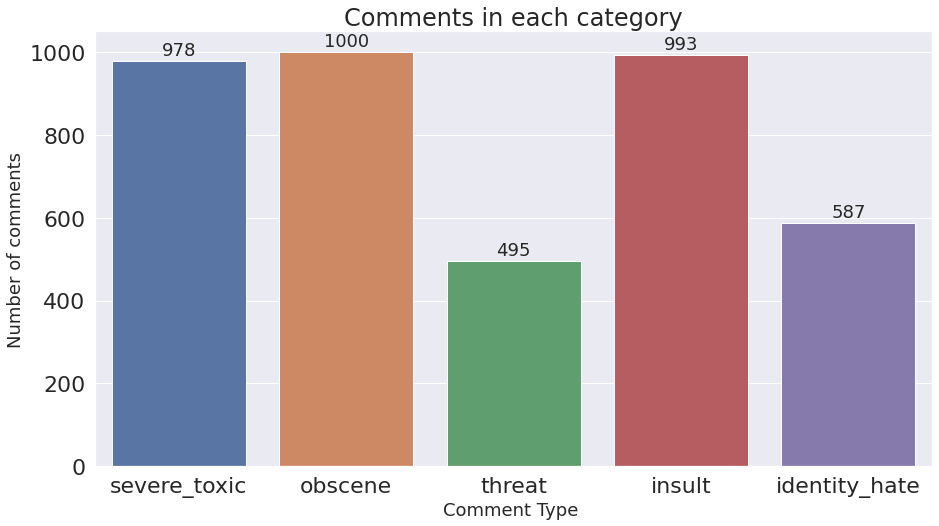

array(['id', 'comment_text', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean_data'], dtype=object)

In [90]:
import seaborn as sns

categories = list(naive_df_training.columns.values)[2:7]
print(categories)
print(naive_df_training.iloc[:,2:7].sum().values)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(x=categories, y=naive_df_training.iloc[:,2:7].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)
#adding the text labels
rects = ax.patches
labels = naive_df_training.iloc[:,2:7].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

df_sampled.columns.values

In [ ]:

a=_df_sampled.append(training_df)
b=a.append(validation_df)
c=b.append(testing_df)
df_sampled_=c



---



['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[1000 1000  547 1000  622]


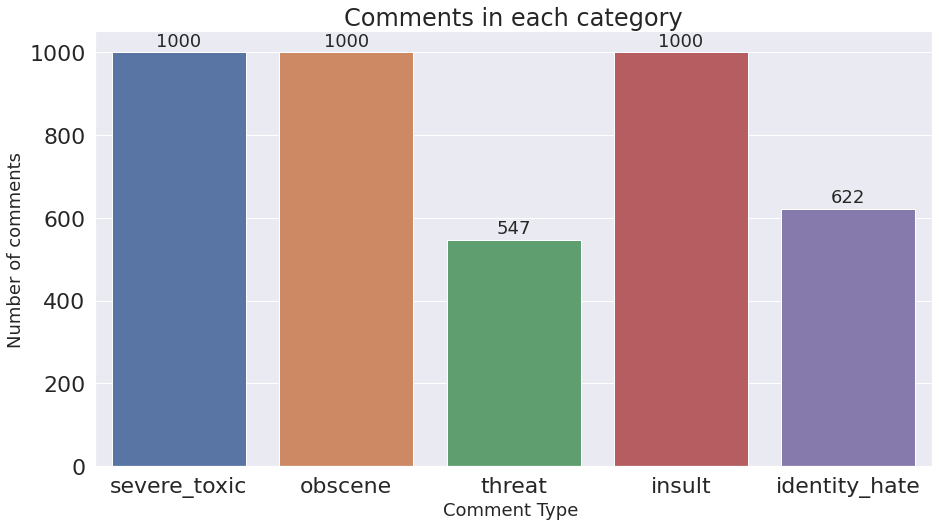

array(['id', 'comment_text', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean_data'], dtype=object)

In [86]:
import seaborn as sns

categories = list(df_sampled.columns.values)[2:7]
print(categories)
print(df_sampled.iloc[:,2:7].sum().values)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(x=categories, y=df_sampled.iloc[:,2:7].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)
#adding the text labels
rects = ax.patches
labels = df_sampled.iloc[:,2:7].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

df_sampled.columns.values

In [91]:
# checkpoint to save df
df_sampled_copy = df_sampled.copy()
# df_sampled = df_sampled_copy.copy()

**K-Means implementation**

In [92]:
# helper functions
from collections import Counter
import math


def dictionary(corpus):
  unique_tokens = sorted(set( t for token_list in corpus for t in token_list ))
  token_id_mapping = { v:i for i,v in enumerate(unique_tokens)}
  return token_id_mapping #{'a':1 , 'b':2 }


def collection_frequency(corpus):
  colFrequency = Counter()
  for d in corpus:
    unique_tokens = set(d)
    for t in unique_tokens:
      colFrequency[t] += 1
  return colFrequency

  # Step 0: Vectorise text

def make_tfidf_sparse(tokens, vocab, coll_freq, N):
  sparse_vector_tfidf = {}
  counts = Counter(tokens)
  for t,c in counts.items():
    # Calclating term frequency tf = 1+ log(noofoccurence of term't'/total no of tokens)
    # adding 1 to log to avoid 0 
    tf = 1 + math.log10(c) if c > 0 else 0
    # Calclating idf tf =  log(total No of docs /doc_frequency of colection ffrquen)
    # adding 1 to log to avoid 0 
    idf = math.log10(N / coll_freq[t])
    sparse_vector_tfidf[vocab[t]] = tf*idf
      
  return sparse_vector_tfidf



In [93]:
import numpy as np
print(df_sampled.shape)
df_sampled['clean_data'] = df_sampled['clean_data'].replace([], np.nan)
df_sampled = df_sampled.dropna(subset=['clean_data'])

print(df_sampled.shape)

(4169, 8)
(4167, 8)


In [94]:
# tokens colleector

# print(len(total_tokens))
# creating dictionary of all words in all docs
token_vocab = dictionary(df_sampled['clean_data'])

# collection frequency of terms
posts_docfreq = collection_frequency(df_sampled['clean_data'])

# total no of docs
N = df_sampled.shape[0]




   Step 0: Vectorise text


In [95]:
posts_tfidf_vectors = [ make_tfidf_sparse(pt, token_vocab, posts_docfreq, N) for pt in df_sampled['clean_data'] ]

In [96]:
# Normalising tfidf vectors to  penalise  the long docs and boost the tfidf score of small docs

def normalize_sparse_vector(sv):
  d = math.sqrt( sum( val*val for index,val in sv.items() ) )
  norm_vector = { index:val/d for index,val in sv.items() }
  return norm_vector


posts_norm_vectors = [ normalize_sparse_vector(sv) for sv in posts_tfidf_vectors ]

In [97]:
print(len(token_vocab))
# token_vocab

# Doc freq for each term
print(len(posts_docfreq))

# for each doc tfidf vector(sparse)
print(len(posts_norm_vectors))

# print(posts_tfidf_vectors[0])

9773
9773
4167


In [98]:
# def sparse_eucledean_distance(sv1, sv2):
#   d2 = 0
#   indices = set(sv1).union(sv2)
#   for i in indices:
#     diff = (sv2.get(i,0)) - (sv1.get(i,0))
#     d2 += diff * diff
#   return math.sqrt(d2)

def dot_product(sparse_vecA, sparseVecB):
  # Initialize dot product to 0
  dot_prod = 0
  
  # Find indices that are common to both sparse vectors
  indices = set(sparse_vecA).intersection(sparseVecB)
  
  # Iterate over common indices and calculate dot product
  for i in indices:
    # Get value from sparse_vecA at index i, or default to 0 if not present
    valA = sparse_vecA.get(i, 0)
    # Get value from sparseVecB at index i, or default to 0 if not present
    valB = sparseVecB.get(i, 0)
    # Add product of values to dot product
    dot_prod += valA * valB
  
  # Return final dot product
  return dot_prod

def calc_cos_similarity(sparse_vecA, sparseVecB):
  # Calculate the Euclidean norm of sv1 and sv2
  d1 = math.sqrt(sum(val*val for index,val in sparse_vecA.items()))
  d2 = math.sqrt(sum(val*val for index,val in sparseVecB.items()))
  
  # If either norm is zero, print the vectors and return None
  if d1 == 0 or d2 == 0:
    print(sparse_vecA, " \n",sparseVecB)
    # print(sum(val*val for index,val in sv1.items()), " \n",sum(val*val for index,val in sv2.items()))
    return None
  
  # Calculate the dot product of sv1 and sv2
  dot_prod = dot_product(sparse_vecA, sparseVecB)
  
  # Calculate the cosine similarity as the dot product divided by the product of the norms
  cosine_similarity = dot_prod / (d1 * d2)
  
  # Return the cosine similarity
  return cosine_similarity


In [100]:
import random

def initial_centroids(num_clusters, vector_dim, random_seed=42):
  # use a random seed to ensure consistent vectors across runs
  rng = random.Random(random_seed)
  centroids = []
  for _ in range(num_clusters):
    new_centroid = {i: rng.random() for i in range(vector_dim)}
    centroids.append(new_centroid)
  return centroids

def assigning_new_clusters(vectors, centroids):
  cluster_ids = []
  for vector in vectors:
    cluster_ids.append(max(range(len(centroids)), key=lambda i: calc_cos_similarity(vector, centroids[i])))
  return cluster_ids


def new_centroids(vectors, cluster_ids):
  centroids = []
  for cluster_id in sorted(set(cluster_ids)):
    cluster_vectors = [v for v, c in zip(vectors, cluster_ids) if c == cluster_id]
    common_keys = set().union(*[k.keys() for k in cluster_vectors])
    centroids.append({i: sum(v.get(i, 0) for v in cluster_vectors)/len(cluster_vectors) for i in common_keys})
  return centroids

def kmeans(num_clusters, vocab, vectors):
  iteration = 0
  print('kmeans starting')

  # Step 1: Pick random centers

  centroids = initial_centroids(num_clusters, len(vocab))

  # Step 2: initial step of assigning each vector its closes centroid
  cluster_ids = assigning_new_clusters(vectors, centroids)
  prev_cluster_ids = cluster_ids

  # if no clusters change then stop kmeans
  while iteration == 0 or count_diff > 0:
    # Step 3: calc the centroids & re-assign
    centroids = new_centroids(vectors, cluster_ids)
    cluster_ids = assigning_new_clusters(vectors, centroids)

    # Repeat until converged
    count_diff = sum(a != b for a, b in zip(cluster_ids, prev_cluster_ids))
    prev_cluster_ids = cluster_ids
    print(f' iteration number={iteration}: and count of vectors reallocated to new cluster {count_diff} ')
    iteration += 1
      
  print(f'kmeans converged')
  return cluster_ids, centroids
cluster_ids, centroids = kmeans(5, token_vocab, posts_norm_vectors)

kmeans starting
 iteration number=0: and count of vectors reallocated to new cluster 1283 
 iteration number=1: and count of vectors reallocated to new cluster 693 
 iteration number=2: and count of vectors reallocated to new cluster 451 
 iteration number=3: and count of vectors reallocated to new cluster 289 
 iteration number=4: and count of vectors reallocated to new cluster 173 
 iteration number=5: and count of vectors reallocated to new cluster 130 
 iteration number=6: and count of vectors reallocated to new cluster 117 
 iteration number=7: and count of vectors reallocated to new cluster 118 
 iteration number=8: and count of vectors reallocated to new cluster 112 
 iteration number=9: and count of vectors reallocated to new cluster 110 
 iteration number=10: and count of vectors reallocated to new cluster 89 
 iteration number=11: and count of vectors reallocated to new cluster 66 
 iteration number=12: and count of vectors reallocated to new cluster 72 
 iteration number=13:

In [115]:
import collections
counter = collections.Counter(cluster_ids)
print("cluster counts",counter)

rev_vocab = {v: k for k, v in token_vocab.items()}
dict_label={0:'severe_toxic,',1:'Obscene',2:'threat',3:'insult',4:'identity_hate'}
for cluster_id in sorted(set(cluster_ids)):
  # matching_posts = [p for p, cid in zip(df_sampled, cluster_ids) if cid == cluster_id]
  intersect_post = []


  cluster_orig= dict_label[cluster_id]
  print('FOR ',cluster_orig)
  print(f'Cluster {cluster_id}  has ({len(intersect_post)} posts)')
  

  print('Top words in each cluster with respective Tf-IDF score:')
  for term_id, score in Counter(centroids[cluster_id]).most_common(5):
    print(" -", rev_vocab[term_id], round(score,4))
  print()
  print()


cluster counts Counter({1: 1629, 4: 803, 2: 710, 3: 652, 0: 373})
FOR  severe_toxic,
Cluster 0  has (0 posts)
Top words in each cluster with respective Tf-IDF score:
 - gay 0.1837
 - homosexual 0.0371
 - pedophile 0.019
 - cure 0.0184
 - edit 0.0182


FOR  Obscene
Cluster 1  has (0 posts)
Top words in each cluster with respective Tf-IDF score:
 - fucking 0.0243
 - idiot 0.0235
 - like 0.0219
 - stupid 0.0194
 - people 0.0185


FOR  threat
Cluster 2  has (0 posts)
Top words in each cluster with respective Tf-IDF score:
 - bitch 0.0401
 - ass 0.0301
 - come 0.0218
 - little 0.0214
 - go 0.0213


FOR  insult
Cluster 3  has (0 posts)
Top words in each cluster with respective Tf-IDF score:
 - die 0.0693
 - suck 0.0667
 - dick 0.0424
 - nigger 0.039
 - cock 0.032


FOR  identity_hate
Cluster 4  has (0 posts)
Top words in each cluster with respective Tf-IDF score:
 - fuck 0.1357
 - kill 0.0603
 - asshole 0.0271
 - bitch 0.0227
 - shit 0.022




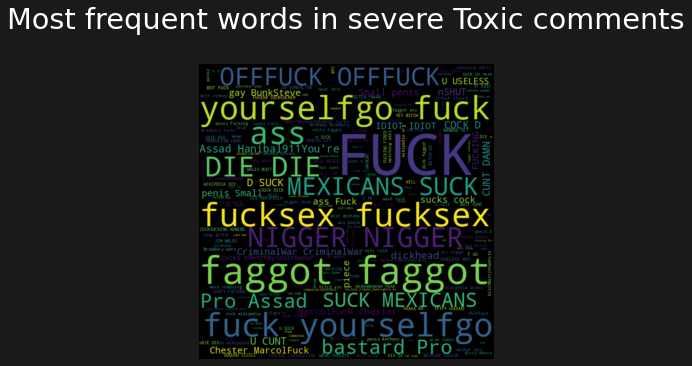

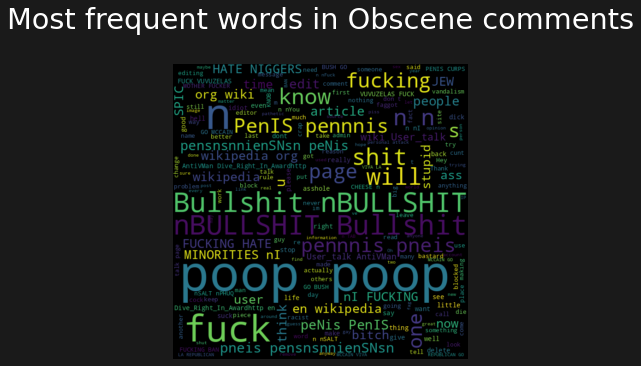

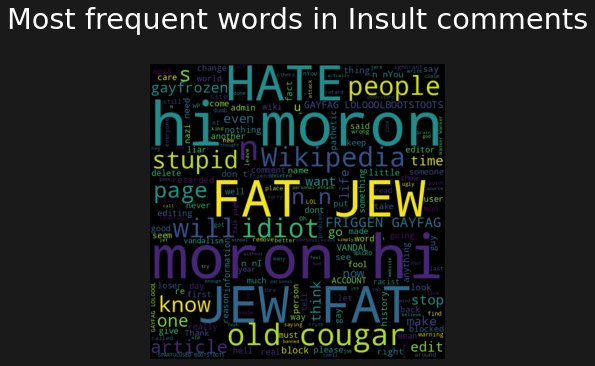

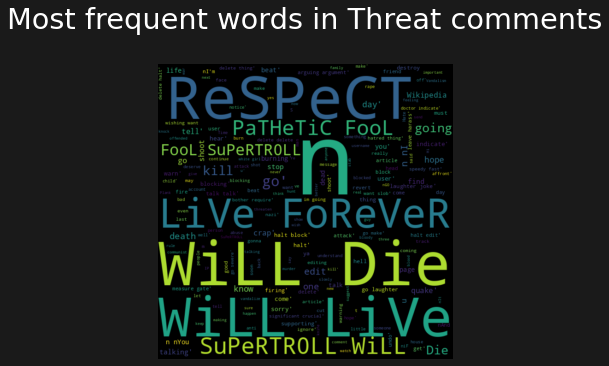

In [116]:
from wordcloud import WordCloud, STOPWORDS

def word_plot(column,text):
    
    comments = df_sampled['comment_text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
# word_plot(df_sampled['toxic'], "Toxic comments")
word_plot(df_sampled['severe_toxic'],"severe Toxic comments")
word_plot(df_sampled['obscene'],"Obscene comments")
word_plot(df_sampled['insult'],"Insult comments")
word_plot(df_sampled['threat'],"Threat comments")

# transforming multiple label columns to one single column with encoded labels 

'severe_toxic'-->0

 'obscene' -->1  
 
 'threat' -->2 
 
 'insult' --> 3 
 
 'identity_hate' -->4


In [109]:
original_clusters=[]
# ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(toxic_labels)
print(df_sampled.columns)
def get_list_oflabels2(df_in):
  # return(df_in[1])
  list_of_labels=[]
  for j in range(2,7):
    if(df_in.iloc[j] == 1 ): list_of_labels.append(toxic_labels[j-2])
  return list_of_labels

dict_labels={'severe_toxic':0, 'obscene':1, 'threat':2, 'insult':3, 'identity_hate':4}
for i, row in df_sampled.iterrows():
# for i in range(len(df.index)):
  # print('Row ',df.iloc[i,1][0:50])
  # l1=get_list_oflabels(df.iloc[i,:])
  l1=get_list_oflabels2(row)
  if(len(l1)==0): print(l1)
  original_clusters.append(dict_labels.get(l1[0]))
# print(df_sampled.iloc[4342,:])

['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Index(['id', 'comment_text', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'clean_data'],
      dtype='object')


In [110]:
print((df_sampled.shape))
df_sampled['final_label'] = np.array(original_clusters)


(4167, 8)


array([[ 47, 233, 167, 192, 360],
       [ 29, 465, 171, 134, 201],
       [ 39,  56, 135, 150, 167],
       [ 47, 708, 162,  65,  17],
       [211, 167,  75, 111,  58]])

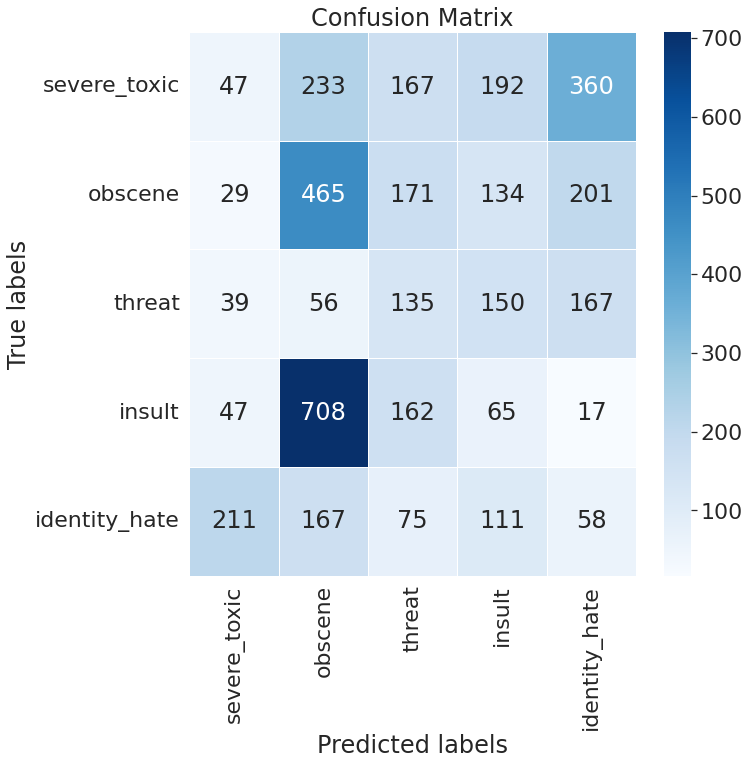

In [122]:
from sklearn.metrics import classification_report,confusion_matrix
cf_matrix=confusion_matrix(original_clusters,cluster_ids)
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
labels = categories
# sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, linewidths=.5,
#             fmt='.2%', cmap='Blues',ax=ax)

x_axis_labels = categories # labels for x-axis
y_axis_labels = categories # labels for y-axis

# create seabvorn heatmap with required labels

# sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,xticklabels=x_axis_labels, yticklabels=y_axis_labels,
#              linewidths=.5,
#             fmt='.2%', cmap='Blues',ax=ax)
sns.heatmap(cf_matrix, annot=True,xticklabels=x_axis_labels, yticklabels=y_axis_labels,
             linewidths=.5,
            fmt='.0f', cmap='Blues',ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
cf_matrix

In [ ]:
df_sampled.columns
# df_sampled.to_csv('new_df_with_sampling_done.csv')


Index(['id', 'comment_text', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'clean_data', 'final_label'],
      dtype='object')

In [ ]:
# Checkpoint cell


import pandas as pd
df_sampled = pd.read_csv('/content/new_df_with_sampling_done.csv')
df_sampled.shape
df_sampled = df_sampled.drop(['Unnamed: 0','severe_toxic', 'obscene', 'threat', 'insult','identity_hate'], axis=1)
# df_sampled = df_sampled.drop(['Unnamed: 0'], axis=1)
df_sampled.columns

Index(['id', 'comment_text', 'clean_data', 'final_label'], dtype='object')

In [ ]:
# # Dropping other labels. and retaining target column 'final label'
# # df_sampled = df_sampled.drop(['severe_toxic', 'obscene', 'threat', 'insult','identity_hate'], axis=1)

# df_sampled = df_sampled.drop(['Unnamed: 0','severe_toxic', 'obscene', 'threat', 'insult','identity_hate'], axis=1)
# # df_sampled = df_sampled.drop(['Unnamed: 0'], axis=1)
# df_sampled.columns



In [ ]:
# df_sampled.reset_index(drop=True, inplace=True)

# df_sampled.head(10)

In [ ]:
df_sampled.shape

(4188, 4)

In [ ]:
import numpy as np
# import pandas as pd

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train_df,validate_df,test_df = train_validate_test_split(df_sampled,0.6, 0.2, seed=None)



---



**Q3 - Comparing Classifiers [10 marks]**

In [ ]:
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns

In [ ]:
def evaluation_metrics_on_validation_set(a):
  testpred = a
  score=accuracy_score(validate_df['final_label'],testpred)
  print("accuracy_score",score)
  print(classification_report(validate_df['final_label'],testpred,digits=3))
  print(confusion_matrix(validate_df['final_label'],testpred))
  a=confusion_matrix(validate_df['final_label'],testpred)
  fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
  sns.heatmap(a,annot=True,ax=ax,fmt='g')

In [ ]:
def evaluation_metrics_on_training_set(a):
  testpred = a
  score=accuracy_score(train_df['final_label'],testpred)
  print(score)
  print(classification_report(train_df['final_label'],testpred,digits=3))
  print(confusion_matrix(train_df['final_label'],testpred))
  a=confusion_matrix(train_df['final_label'],testpred)
  sns.heatmap(a,annot=True,fmt='g')

accuracy_score 0.2467065868263473
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       172
           1      0.247     1.000     0.396       206
           2      0.000     0.000     0.000       125
           3      0.000     0.000     0.000       204
           4      0.000     0.000     0.000       128

    accuracy                          0.247       835
   macro avg      0.049     0.200     0.079       835
weighted avg      0.061     0.247     0.098       835

[[  0 172   0   0   0]
 [  0 206   0   0   0]
 [  0 125   0   0   0]
 [  0 204   0   0   0]
 [  0 128   0   0   0]]


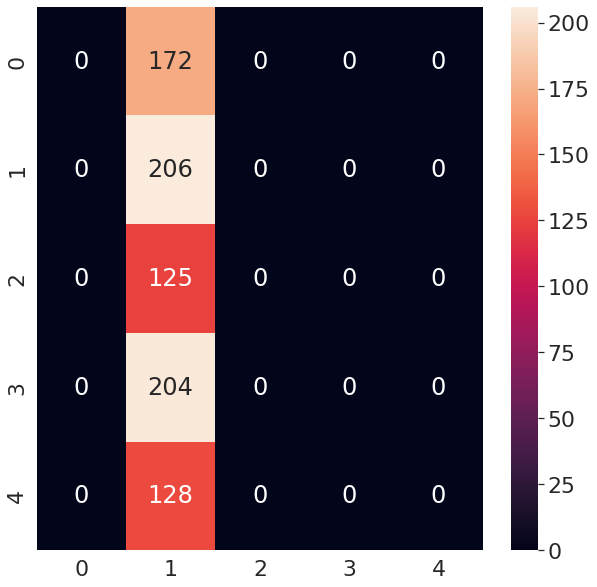

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_df["clean_data"], train_df['final_label'])
pred_dummymf = dummy_clf.predict(validate_df["clean_data"])
evaluation_metrics_on_validation_set(pred_dummymf)

0.24022346368715083
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       600
           1      0.240     1.000     0.387       602
           2      0.000     0.000     0.000       314
           3      0.000     0.000     0.000       597
           4      0.000     0.000     0.000       393

    accuracy                          0.240      2506
   macro avg      0.048     0.200     0.077      2506
weighted avg      0.058     0.240     0.093      2506

[[  0 600   0   0   0]
 [  0 602   0   0   0]
 [  0 314   0   0   0]
 [  0 597   0   0   0]
 [  0 393   0   0   0]]


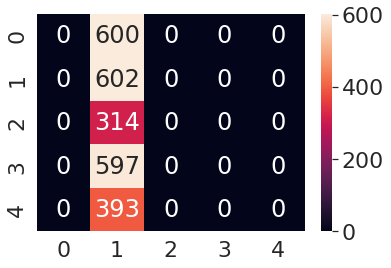

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_df["clean_data"], train_df['final_label'])
pred_dummymf_train = dummy_clf.predict(train_df["clean_data"])
evaluation_metrics_on_training_set(pred_dummymf_train)

accuracy_score 0.21077844311377245
              precision    recall  f1-score   support

           0      0.229     0.256     0.242       172
           1      0.223     0.223     0.223       206
           2      0.162     0.128     0.143       125
           3      0.242     0.245     0.243       204
           4      0.153     0.156     0.154       128

    accuracy                          0.211       835
   macro avg      0.202     0.202     0.201       835
weighted avg      0.209     0.211     0.209       835

[[44 37 17 41 33]
 [45 46 29 59 27]
 [27 34 16 24 24]
 [49 54 24 50 27]
 [27 35 13 33 20]]


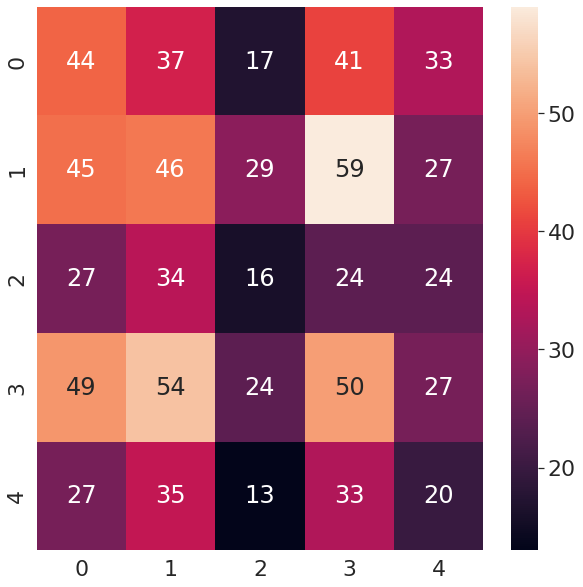

In [ ]:
dummy_clf_startified = DummyClassifier(strategy="stratified")
dummy_clf_startified.fit(train_df["clean_data"], train_df['final_label'])
pred_dummyf_startified = dummy_clf_startified.predict(validate_df["clean_data"])
evaluation_metrics_on_validation_set(pred_dummyf_startified)

0.20550678371907422
              precision    recall  f1-score   support

           0      0.216     0.220     0.218       600
           1      0.244     0.252     0.248       602
           2      0.126     0.118     0.122       314
           3      0.237     0.233     0.235       597
           4      0.141     0.140     0.140       393

    accuracy                          0.206      2506
   macro avg      0.193     0.193     0.193      2506
weighted avg      0.205     0.206     0.205      2506

[[132 141  74 147 106]
 [152 152  75 138  85]
 [ 84  80  37  67  46]
 [153 143  64 139  98]
 [ 90 108  44  96  55]]


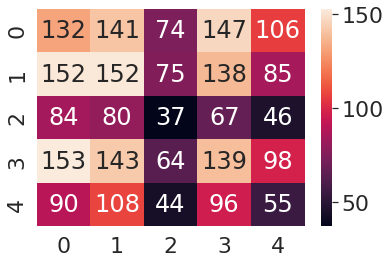

In [ ]:
dummy_clf_startified = DummyClassifier(strategy="stratified")
dummy_clf_startified.fit(train_df["clean_data"], train_df['final_label'])
pred_dummyf_startified = dummy_clf_startified.predict(train_df["clean_data"])
evaluation_metrics_on_training_set(pred_dummyf_startified)

**one-hot encoding vectorizer.**

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

from spacy.lang.en.stop_words import STOP_WORDS
stop = STOP_WORDS
def text_preprocessing_func(text):
    tokens = []
    # print('hi')
    doc = nlp(text)
    if(doc is None): print(doc)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space and not t.like_url and not t.like_num:
            tokens.append(t.lemma_.lower())
    return tokens

one hot vectoriser

In [ ]:
# train_df,validate_df,test_df


one_hot_vectorizer = CountVectorizer(tokenizer=text_preprocessing_func)
train_features_ohv = one_hot_vectorizer.fit_transform(train_df['comment_text'].tolist())
validation_features_ohv = one_hot_vectorizer.transform(validate_df['comment_text'])
test_features_ohv = one_hot_vectorizer.transform(test_df['comment_text'])

TFIDF Vectoriser

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=text_preprocessing_func)
train_features_tfidf = tf_idf_vectorizer.fit_transform(train_df['comment_text'].tolist())
validation_features_tfidf = tf_idf_vectorizer.transform(validate_df['comment_text'])
test_features_tfidf = tf_idf_vectorizer.transform(test_df['comment_text'])

accuracy_score 0.6311377245508982
              precision    recall  f1-score   support

           0      0.633     0.663     0.648       172
           1      0.522     0.403     0.455       206
           2      0.678     0.824     0.744       125
           3      0.632     0.706     0.667       204
           4      0.716     0.648     0.680       128

    accuracy                          0.631       835
   macro avg      0.636     0.649     0.639       835
weighted avg      0.625     0.631     0.624       835

[[114  48   4   6   0]
 [ 61  83  13  44   5]
 [  1   4 103  10   7]
 [  3  20  16 144  21]
 [  1   4  16  24  83]]


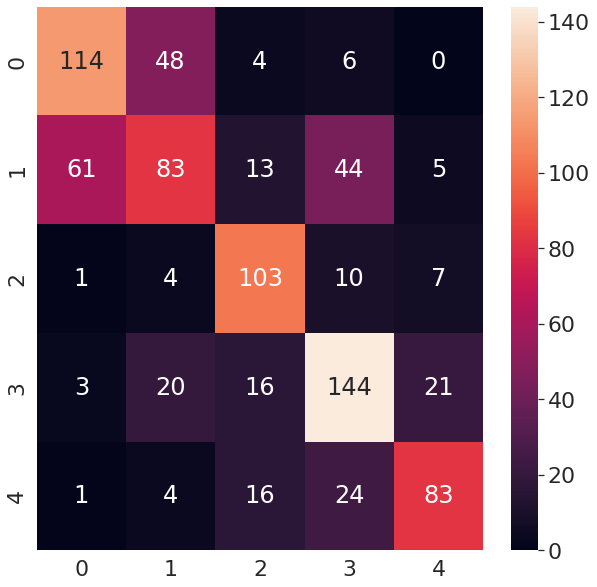

In [ ]:
logisticRegressionModel = LogisticRegression()

#One-hot vectorization
logisticRegressionModel.fit(train_features_ohv, train_df['final_label'])

y_pred_one_hot = logisticRegressionModel.predict(validation_features_ohv)
evaluation_metrics_on_validation_set(y_pred_one_hot)



0.942537909018356
              precision    recall  f1-score   support

           0      0.940     0.965     0.952       600
           1      0.982     0.902     0.940       602
           2      0.845     0.990     0.912       314
           3      0.966     0.966     0.966       597
           4      0.946     0.896     0.920       393

    accuracy                          0.943      2506
   macro avg      0.936     0.944     0.938      2506
weighted avg      0.945     0.943     0.943      2506

[[579   9   6   2   4]
 [ 32 543   5  17   5]
 [  0   0 311   0   3]
 [  5   1   6 577   8]
 [  0   0  40   1 352]]


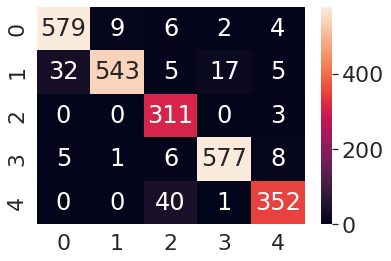

In [ ]:
y_pred_one_hot = logisticRegressionModel.predict(train_features_ohv)
evaluation_metrics_on_training_set(y_pred_one_hot)


accuracy_score 0.6215568862275449
              precision    recall  f1-score   support

           0      0.640     0.651     0.646       172
           1      0.509     0.403     0.450       206
           2      0.888     0.632     0.738       125
           3      0.540     0.828     0.654       204
           4      0.800     0.594     0.682       128

    accuracy                          0.622       835
   macro avg      0.675     0.622     0.634       835
weighted avg      0.645     0.622     0.619       835

[[112  45   3  10   2]
 [ 59  83   1  61   2]
 [  1   6  79  36   3]
 [  2  21   0 169  12]
 [  1   8   6  37  76]]


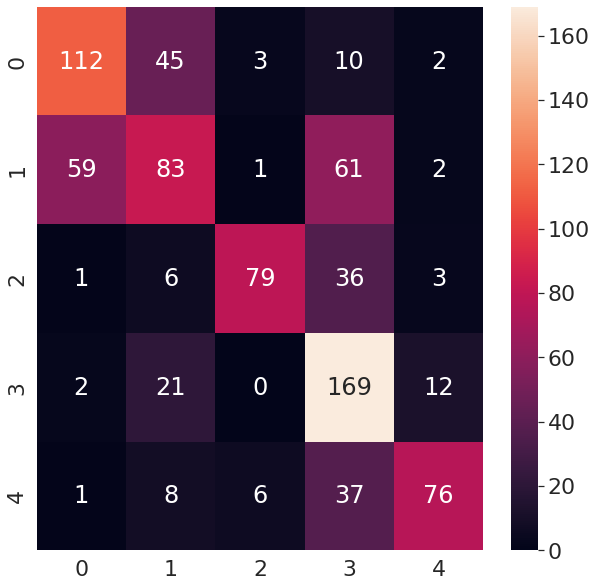

In [ ]:
logisticRegressionModel_tfIDF = LogisticRegression()
# tfidf vectorization 
logisticRegressionModel_tfIDF.fit(train_features_tfidf, train_df['final_label'])
y_tfidf_pred = logisticRegressionModel_tfIDF.predict(validation_features_tfidf)
evaluation_metrics_on_validation_set(y_tfidf_pred)


As Logistic regression was best model so  f1 score bar graph


              precision    recall  f1-score     support
0              0.640000  0.651163  0.645533  172.000000
1              0.509202  0.402913  0.449864  206.000000
2              0.887640  0.632000  0.738318  125.000000
3              0.539936  0.828431  0.653772  204.000000
4              0.800000  0.593750  0.681614  128.000000
accuracy       0.621557  0.621557  0.621557    0.621557
macro avg      0.675356  0.621651  0.633820  835.000000
weighted avg   0.644884  0.621557  0.618694  835.000000


<BarContainer object of 5 artists>

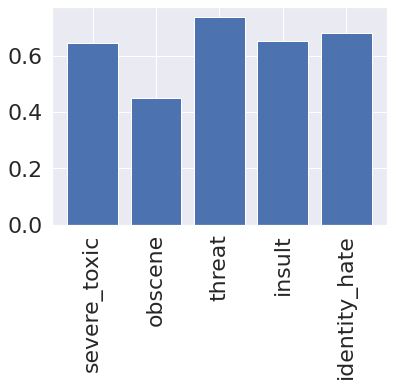

In [ ]:
crep = classification_report(validate_df['final_label'],y_tfidf_pred,output_dict = True)
dataframe_rep = pd.DataFrame(crep).T
print(dataframe_rep)

plt.xticks(rotation='vertical')
toxic_labels = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

plt.xticks([1, 2, 3,4,5], toxic_labels)
plt.bar([1, 2, 3,4,5], dataframe_rep['f1-score'].iloc[0:5])

0.8850758180367119
              precision    recall  f1-score   support

           0      0.901     0.912     0.906       600
           1      0.934     0.847     0.889       602
           2      0.885     0.783     0.831       314
           3      0.812     0.970     0.884       597
           4      0.928     0.855     0.890       393

    accuracy                          0.885      2506
   macro avg      0.892     0.873     0.880      2506
weighted avg      0.890     0.885     0.885      2506

[[547  26   7  17   3]
 [ 53 510   1  30   8]
 [  2   5 246  52   9]
 [  5   3   4 579   6]
 [  0   2  20  35 336]]


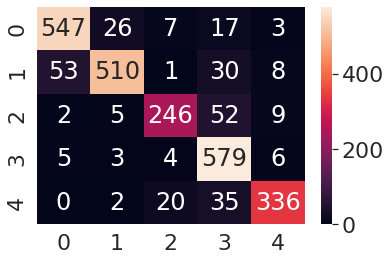

In [ ]:
y_tfidf_pred = logisticRegressionModel_tfIDF.predict(train_features_tfidf)
evaluation_metrics_on_training_set(y_tfidf_pred)

SVC Classifier with  One-hot vectorization


accuracy_score 0.3029940119760479
              precision    recall  f1-score   support

           0      0.778     0.081     0.147       172
           1      0.260     0.951     0.408       206
           2      0.000     0.000     0.000       125
           3      0.683     0.211     0.322       204
           4      0.000     0.000     0.000       128

    accuracy                          0.303       835
   macro avg      0.344     0.249     0.176       835
weighted avg      0.391     0.303     0.210       835

[[ 14 156   0   2   0]
 [  3 196   0   7   0]
 [  0 124   0   1   0]
 [  1 160   0  43   0]
 [  0 118   0  10   0]]


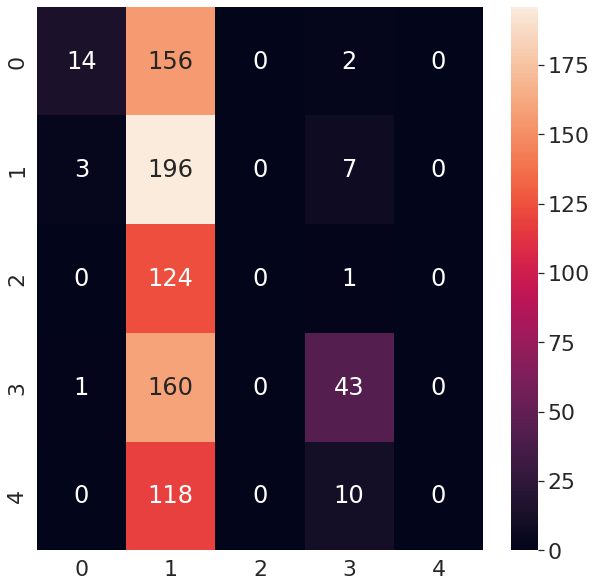

In [ ]:
svc = SVC(kernel='rbf')

#model training 
svc.fit(train_features_ohv, train_df['final_label'])

#predict 
y_svc = svc.predict(validation_features_ohv)

evaluation_metrics_on_validation_set(y_svc)

0.3399840383080607
              precision    recall  f1-score   support

           0      0.945     0.115     0.205       600
           1      0.267     0.980     0.420       602
           2      1.000     0.003     0.006       314
           3      0.857     0.320     0.466       597
           4      1.000     0.003     0.005       393

    accuracy                          0.340      2506
   macro avg      0.814     0.284     0.220      2506
weighted avg      0.777     0.340     0.263      2506

[[ 69 524   0   7   0]
 [  3 590   0   9   0]
 [  0 310   1   3   0]
 [  1 405   0 191   0]
 [  0 379   0  13   1]]


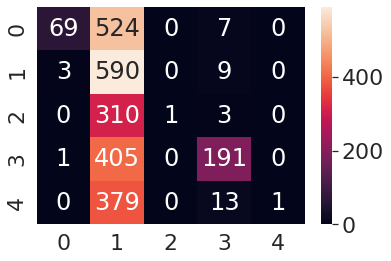

In [ ]:
y_svc = svc.predict(train_features_ohv)

evaluation_metrics_on_training_set(y_svc)

# Q3 b  Random Forest as extra classifier


accuracy_score 0.6119760479041916
              precision    recall  f1-score   support

           0      0.568     0.727     0.638       172
           1      0.525     0.257     0.345       206
           2      0.615     0.856     0.716       125
           3      0.636     0.745     0.686       204
           4      0.733     0.578     0.646       128

    accuracy                          0.612       835
   macro avg      0.615     0.633     0.606       835
weighted avg      0.606     0.612     0.590       835

[[125  31   4   9   3]
 [ 90  53  19  40   4]
 [  1   3 107  13   1]
 [  3   8  22 152  19]
 [  1   6  22  25  74]]


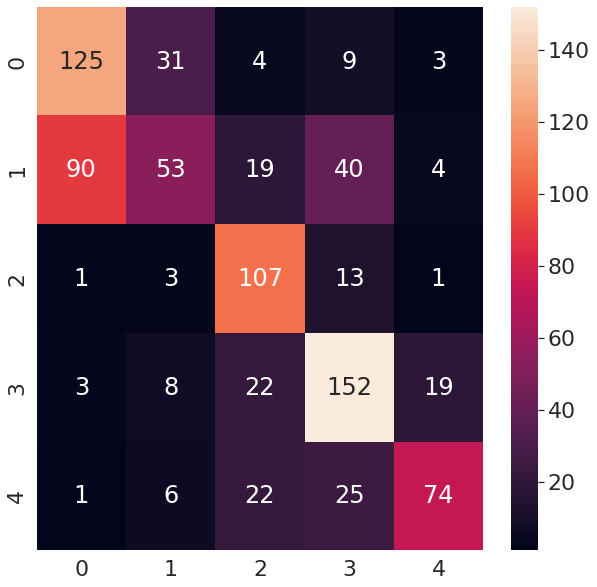

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_features_tfidf, train_df['final_label'])
y_pred_random = clf.predict(validation_features_tfidf)
evaluation_metrics_on_validation_set(y_pred_random)

## Q2:CV and parameter tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
tf_idf_vectorizer_cv = TfidfVectorizer(tokenizer=text_preprocessing_func,max_features=1800, sublinear_tf=True,stop_words="english")
train_tfidf_cv = tf_idf_vectorizer_cv.fit_transform(train_df['comment_text'].tolist())
test_tfidf_cv = tf_idf_vectorizer_cv.transform(test_df['comment_text'])





In [ ]:
val_tfidf_cv = tf_idf_vectorizer_cv.transform(validate_df['comment_text'])


In [ ]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=text_preprocessing_func)),
    ('classify', LogisticRegression())
])
# 1. Classifier - Regularisation C value (typical values might be powers of 10 (from 10^-3 to 10^5)
# 2. Vectorizer - Parameters: sublinear_tf and max_features (vocabulary size) (in a range None to 50k)
params = {
    'vectorizer__sublinear_tf': [True],
    'classify__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'vectorizer__max_features': [1800],
    'vectorizer__stop_words':['english']
}
# n_jobs=-1 is throwing error
gscv = GridSearchCV(pipeline, cv=4, n_jobs=1, param_grid=params, verbose=1, scoring='accuracy')

gscv.fit(train_df['comment_text'].tolist(), train_df['final_label'])

Fitting 4 folds for each of 9 candidates, totalling 36 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(tokenizer=<function process_text at 0x7fc9503a9c10>)),
                                       ('classify', LogisticRegression())]),
             n_jobs=1,
             param_grid={'classify__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                         10000, 100000],
                         'vectorizer__max_features': [1800],
                         'vectorizer__stop_words': ['english'],
                         'vectorizer__sublinear_tf': [True]},
             scoring='accuracy', verbose=1)

ETA 25 min for above cell

In [ ]:
# extract best estimator
print(gscv.best_estimator_)
best_estimator = gscv.best_estimator_

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=1800, stop_words='english',
                                 sublinear_tf=True,
                                 tokenizer=<function process_text at 0x7fc9503a9c10>)),
                ('classify', LogisticRegression(C=10))])


accuracy_score 0.6119760479041916
              precision    recall  f1-score   support

           0      0.599     0.616     0.607       172
           1      0.452     0.388     0.418       206
           2      0.775     0.856     0.814       125
           3      0.570     0.662     0.612       204
           4      0.783     0.648     0.709       128

    accuracy                          0.612       835
   macro avg      0.636     0.634     0.632       835
weighted avg      0.610     0.612     0.608       835

[[106  48   3  12   3]
 [ 58  80   8  56   4]
 [  2   3 107  12   1]
 [  8  39   7 135  15]
 [  3   7  13  22  83]]


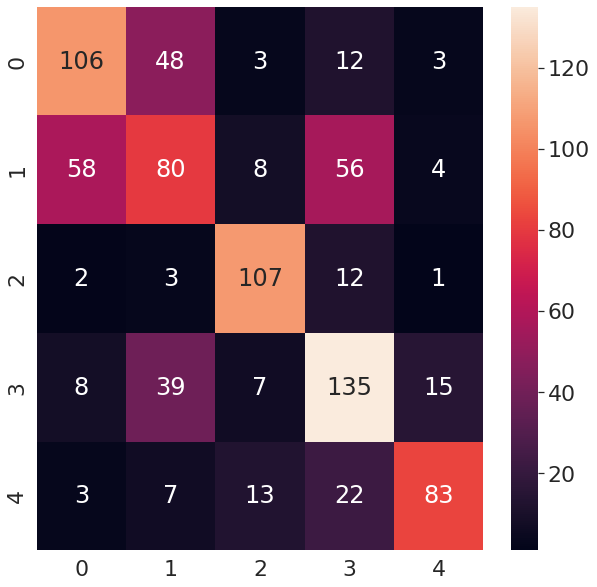

In [ ]:
#Logistic Regression with Regularisation C
# Apply logistic regression model to training data
lr = LogisticRegression(C = 10, solver='liblinear')
lr.fit(train_tfidf_cv,train_df['final_label'])
    
# Predict using model
test_pred_tfidf_tune = lr.predict(val_tfidf_cv)
evaluation_metrics_on_validation_set(test_pred_tfidf_tune)




---



---



---



BERT

In [59]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.8 MB/s eta 0:00:00


Get first context vector for each training dataset

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [ ]:
start = time.time()
def encode_text(text):
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True, max_length=256,)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    return outputs[0][:, 0, :].detach().numpy()  # Take the first context vector

train_set_en = train_df['comment_text'].apply(encode_text)
valid_set_enc = validate_df['comment_text'].apply(encode_text)
end = time.time()
print(start-end)

In [ ]:
train_set_enc_flattened = [x.flatten() for x in train_set_en]
valid_set_enc_flattened = [x.flatten() for x in valid_set_enc]

target_train_bert = train_df.final_label
target_val_bert =validate_df.final_label


model_lr = LogisticRegression(max_iter=1000)

# np_train_data = train_data.to_numpy()
# nsamples, nx, ny = np_train_data.shape
# train_data_set = np_train_data.reshape((nsamples,nx*ny))
model_lr.fit(train_set_enc_flattened, target_train_bert)

preds_valid = model_lr.predict(valid_set_enc_flattened)

preds_train = model_lr.predict(train_set_enc_flattened)


t_acc = accuracy_score(train_df['final_label'], preds_train)
#  Model performance on Validation set
v_acc = accuracy_score(validate_df['final_label'], preds_valid)

In [ ]:
print(v_acc)
print(t_acc)

0.5916167664670658
0.6759776536312849


In [ ]:
from torch.utils.data import Dataset


class TextDataset(Dataset):
   def __init__(self, encodings, labels):
       self.encodings = encodings
       self.labels = labels


   def __getitem__(self, idx):
       item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
       item['labels'] = torch.tensor(self.labels[idx])
       return item


   def __len__(self):
       return len(self.labels)


train_set_en = tokenizer(train_df['comment_text'].tolist(), truncation=True, padding=True)
valid_set_enc = tokenizer(validate_df['comment_text'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['comment_text'].tolist(),truncation=True, padding=True)
train_dataset = TextDataset(train_set_en, train_df['final_label'].tolist())
valid_dataset = TextDataset(valid_set_enc, validate_df['final_label'].tolist())
test_dataset = TextDataset(test_encodings, test_df['final_label'].tolist())


In [ ]:
from sklearn.metrics import accuracy_score, f1_score


def metric_evaluate_function(pred):
   labels = pred.label_ids
   preds = pred.predictions.argmax(-1)
   acc = accuracy_score(labels, preds)
   f1 = f1_score(labels, preds, average='weighted')
   return {'accuracy': acc, 'f1': f1}

   



---



---



In [ ]:
training_args = TrainingArguments(
   output_dir='./results',
   num_train_epochs=1,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=64,
   learning_rate=1e-4,
   weight_decay=0.0,
   logging_dir='./logs',
   logging_steps=10,
   evaluation_strategy="epoch",
  
)
trainer = Trainer(
   model=model,                     
   args=training_args,              
   train_dataset=train_dataset,
   eval_dataset=valid_dataset,
   compute_metrics=metric_evaluate_function
)


trainer.train()
eval_result = trainer.evaluate(eval_dataset=valid_dataset)


print(f"Validation Loss: {eval_result['eval_loss']:.3f}")
print(f"Validation Accuracy: {eval_result['eval_accuracy']:.3f}")
print(f"Validation F1-Score: {eval_result['eval_f1']:.3f}")


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.913700,0.826520,0.635928,0.606949


Validation Loss: 0.827
Validation Accuracy: 0.636
Validation F1-Score: 0.607


5b experiment1

In [ ]:
training_args = TrainingArguments(
   output_dir='./results',
   num_train_epochs=3,
   per_device_train_batch_size=8,
   per_device_eval_batch_size=32,
   learning_rate=2e-4,
   weight_decay=0.0,
   logging_dir='./logs',
   logging_steps=10,
   evaluation_strategy="epoch",
  
)
trainer = Trainer(
   model=model,                     
   args=training_args,              
   train_dataset=train_dataset,
   eval_dataset=valid_dataset,
   compute_metrics=metric_evaluate_function
)


trainer.train()
eval_result = trainer.evaluate(eval_dataset=valid_dataset)




/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.513600,1.807038,0.146108,0.037252
2,1.369200,2.640937,0.146108,0.037252
3,1.252600,2.352712,0.146108,0.037252


Experiment2:

In [ ]:
training_args = TrainingArguments(
   output_dir='./results',
   num_train_epochs=3,
   per_device_train_batch_size=8,
   per_device_eval_batch_size=8,
   learning_rate=1e-6,
   weight_decay=0.12,
   logging_dir='./logs',
   logging_steps=10,
   evaluation_strategy="epoch",
  
)
trainer = Trainer(
   model=model,                     
   args=training_args,              
   train_dataset=train_dataset,
   eval_dataset=valid_dataset,
   compute_metrics=metric_evaluate_function
)


trainer.train()
eval_result = trainer.evaluate(eval_dataset=valid_dataset)



/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.540700,1.537320,0.292216,0.205022
2,1.405500,1.412727,0.395210,0.320142
3,1.353800,1.385031,0.398802,0.324626


Experiment 3:

In [ ]:
training_args = TrainingArguments(
   output_dir='./results',
   num_train_epochs=3,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=64,
   learning_rate=1e-5,
   weight_decay=0.02,
   logging_dir='./logs',
   logging_steps=10,
   evaluation_strategy="epoch",
  
)
trainer = Trainer(
   model=model,                     
   args=training_args,              
   train_dataset=train_dataset,
   eval_dataset=valid_dataset,
   compute_metrics=metric_evaluate_function
)


trainer.train()
eval_result = trainer.evaluate(eval_dataset=valid_dataset)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.007500,0.973007,0.566467,0.514110
2,0.757900,0.849993,0.627545,0.610054
3,0.711200,0.789975,0.646707,0.630803


Experiment 4: 

In [ ]:
training_args = TrainingArguments(
   output_dir='./results',
   num_train_epochs=5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=64,
   learning_rate=1e-5,
   weight_decay=0.0002,
   logging_dir='./logs',
   logging_steps=10,
   evaluation_strategy="epoch",
  
)
trainer = Trainer(
   model=model,                     
   args=training_args,              
   train_dataset=train_dataset,
   eval_dataset=valid_dataset,
   compute_metrics=metric_evaluate_function
)


trainer.train()
eval_result = trainer.evaluate(eval_dataset=valid_dataset)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.987800,0.872301,0.605988,0.578911
2,0.696600,0.778635,0.658683,0.641679
3,0.663300,0.730382,0.681437,0.665931
4,0.582700,0.730448,0.708982,0.699717
5,0.477600,0.738312,0.687425,0.672386


Experiment on test:


In [ ]:

eval_result = trainer.evaluate(eval_dataset=test_dataset)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.864800,0.875084,0.608852,0.557356
2,0.760400,0.778015,0.618421,0.592072
3,0.640900,0.744964,0.681818,0.663391
4,0.626700,0.734755,0.709330,0.704905


In [ ]:
def test_report_score(inp):
  pred_test = inp

  score = accuracy_score(test_df['final_label'],pred_test)

  print(classification_report(test_df['final_label'],pred_test,digits=3))
  print(confusion_matrix(test_df['final_label'],pred_test))

  inp=confusion_matrix(test_df['final_label'],pred_test)
  sns.heatmap(inp,annot=True,cmap="YlGnBu",fmt='g')

              precision    recall  f1-score   support

           0      0.688     0.840     0.756       181
           1      0.647     0.516     0.574       192
           2      0.882     0.620     0.728       121
           3      0.732     0.785     0.758       219
           4      0.669     0.772     0.717       123

    accuracy                          0.709       836
   macro avg      0.724     0.707     0.707       836
weighted avg      0.715     0.709     0.705       836

[[152  23   0   6   0]
 [ 66  99   0  27   0]
 [  1   1  75  10  34]
 [  2  29   3 172  13]
 [  0   1   7  20  95]]


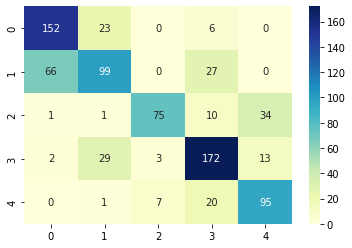

In [ ]:
# eval_result = test_trainer.evaluate(eval_dataset=test_df)
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
test_predictions = trainer.predict(test_dataset).predictions.argmax(axis=-1)
test_report_score(test_predictions)

Run below Cell to free GPU memory

In [ ]:
!nvidia-smi -L  
# !pip install numba

from numba import cuda 
device = cuda.get_current_device()
cuda.get_current_device().reset()
print('GPU RAM is cleared')

GPU 0: Tesla T4 (UUID: GPU-13828c7e-fa5d-c8f3-d9b4-2a36d2a46427)
GPU RAM is cleared


In [ ]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 8.3 GB  |     Proc size: 3.4 GB
GPU RAM Free: 15098MB | Used: 3MB | Util   0% | Total     15360MB


GPU 0: Tesla T4 (UUID: GPU-15c634aa-211c-371b-aa2f-5830b17340a1)
